<a href="https://colab.research.google.com/github/leehimcm/AI-SS-ASSISTANT-AI/blob/main/ppo_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ppo_v5
* 반복 실험 수정
* 성능 향상


### 구글 드라이브 마운트 (필요 시 사용)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# # 작업 디렉토리 변경
# import os
# print(os.getcwd(), end=' -> ')
# os.chdir('/content/drive/MyDrive/Colab Notebooks/25-capstone')
# print(os.getcwd())

### 라이브러리, 한글폰트 설치

In [ ]:
!pip install pulp gymnasium==0.28.1 tianshou==1.2.0 numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pettingzoo to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.1/273.1 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 22.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installat

### import

In [ ]:
import random
import numpy as np
from datetime import date, datetime, timedelta, time
from typing import List, Dict, Optional, Tuple
from collections import defaultdict, deque
import pulp

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

import gymnasium as gym
from gymnasium import spaces

import tianshou as ts
from tianshou.env import DummyVectorEnv
from tianshou.utils.net.common import Net
from tianshou.utils.net.discrete import Actor, Critic
from tianshou.policy import PPOPolicy
from tianshou.data import Collector
from torch.distributions import Categorical, Distribution

from tianshou.utils.logger.tensorboard import TensorboardLogger
from tianshou.trainer import OnpolicyTrainer

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 내부 데이터(전역 데이터)

*   cleaning_tasks: 청소 관련 정보 포함됨, 수정되지 않는 데이터
*   user_cleaning_status: 사용자 청소 기록 데이터 (앱에서 받아 온 청소 완료 기록 데이터 기반으로 수정됨)
* user_execution_data:




In [ ]:
# cleaning_tasks: 청소 관련 정보 포함됨, 수정되지 않는 데이터
cleaning_tasks = [
    {"주방 - 수건 교체": {"duration": 5 / 60, "interval": 5, "description": "깨끗한 수건으로 교체 후 사용한 수건은 세탁 바구니에 넣기"}},
    {"주방 - 행주 삶기": {"duration": 10 / 60, "interval": 7, "description": "행주를 삶거나 세탁기에 고온세탁하여 위생 관리"}},
    {"주방 - 배기후드 기름떼 제거": {"duration": 20 / 60, "interval": 30, "description": "기름 제거제를 뿌리고 문질러 닦은 후 물로 헹구기"}},
    {"주방 - 냉장고 유통기한 지난 음식 1개 이상 처분": {"duration": 10 / 60, "interval": 7, "description": "유통기한 지난 식품 확인 후 폐기"}},

    {"세탁실 - 세탁기 세제통 씻기": {"duration": 10 / 60, "interval": 30, "description": "세제 찌꺼기를 제거하고 물로 헹군 후 건조"}},

    {"화장실 - 바닥 청소": {"duration": 10 / 60, "interval": 14, "description": "바닥에 락스를 뿌리고 청소솔과 세제로 구석구석 닦기"}},
    {"화장실 - 변기 청소": {"duration": 10 / 60, "interval": 7, "description": "변기 전용 세제로 내부와 테두리 문지르기"}},
    {"화장실 - 세면대 청소": {"duration": 7 / 60, "interval": 5, "description": "물때와 치약 자국 등을 세정제로 제거"}},
    {"화장실 - 하수구 청소": {"duration": 10 / 60, "interval": 7, "description": "막힘 방지용 세정제 또는 끓는 물로 청소"}},
    {"화장실 - 거울 닦기": {"duration": 5 / 60, "interval": 7, "description": "유리세정제로 물자국 닦기"}},
    {"화장실 - 수납장 내부 정리 및 청소": {"duration": 15 / 60, "interval": 90, "description": "모든 물건 꺼내고 내부를 닦은 후 재정리"}},

    {"거실 - 가구 표면 먼지 닦기 (물걸레)": {"duration": 5 / 60, "interval": 14, "description": "물에 적신 걸레로 가구 표면 닦기"}},
    {"거실 - 가구 표면 먼지 털기 (먼지털이)": {"duration": 5 / 60, "interval": 7, "description": "먼지털이개로 가볍게 먼지를 털어냄"}},
    {"거실 - 바닥 물걸레질": {"duration": 15 / 60, "interval": 3, "description": "청소기로 먼지 제거 후 물걸레질"}},
    {"거실 - 청소기로 바닥 먼지 제거": {"duration": 10 / 60, "interval": 2, "description": "진공청소기로 바닥과 카펫 먼지 제거"}},
    {"거실 - 테이블 위 정리": {"duration": 5 / 60, "interval": 2, "description": "불필요한 물건 정리 및 정돈"}},
    {"거실 - 안 쓰는 물건 1개 이상 처분": {"duration": 7 / 60, "interval": 10, "description": "수납공간 내 불필요한 물건 정리 및 기부/폐기"}},

    {"창틀 먼지 닦기": {"duration": 10 / 60, "interval": 14, "description": "젖은 걸레나 진공청소기를 이용해 틈새 먼지 제거"}},
    {"전자기기 소독": {"duration": 5 / 60, "interval": 5, "description": "알콜스왑이나 알콜티슈로 스마트폰, 컴퓨터 등 표면 닦기"}},
    {"쓰레기 배출": {"duration": 10 / 60, "interval": 4, "description": "생활 쓰레기 및 분리수거된 품목을 지정 장소에 배출"}},
    {"음식물 쓰레기 배출": {"duration": 5 / 60, "interval": 3, "description": "음식물 쓰레기를 지정 장소에 배출"}},
]

# user_cleaning_status: 사용자 청소 기록 데이터 (앱에서 받아 온 청소 완료 기록 데이터 기반으로 수정됨)
# last_done_days_ago: cleaning_tasks의 interval + 3 값으로
user_cleaning_status = {
    "주방 - 수건 교체": {"last_done_days_ago": 8},
    "주방 - 행주 삶기": {"last_done_days_ago": 10},
    "주방 - 배기후드 기름떼 제거": {"last_done_days_ago": 33},
    "주방 - 냉장고 유통기한 지난 음식 1개 이상 처분": {"last_done_days_ago": 10},

    "세탁실 - 세탁기 세제통 씻기": {"last_done_days_ago": 33},

    "화장실 - 바닥 청소": {"last_done_days_ago": 17},
    "화장실 - 변기 청소": {"last_done_days_ago": 10},
    "화장실 - 세면대 청소": {"last_done_days_ago": 8},
    "화장실 - 하수구 청소": {"last_done_days_ago": 10},
    "화장실 - 거울 닦기": {"last_done_days_ago": 10},
    "화장실 - 수납장 내부 정리 및 청소": {"last_done_days_ago": 93},

    "거실 - 가구 표면 먼지 닦기 (물걸레)": {"last_done_days_ago": 17},
    "거실 - 가구 표면 먼지 털기 (먼지털이)": {"last_done_days_ago": 10},
    "거실 - 바닥 물걸레질": {"last_done_days_ago": 6},
    "거실 - 청소기로 바닥 먼지 제거": {"last_done_days_ago": 5},
    "거실 - 테이블 위 정리": {"last_done_days_ago": 5},
    "거실 - 안 쓰는 물건 1개 이상 처분": {"last_done_days_ago": 13},

    "창틀 먼지 닦기": {"last_done_days_ago": 17},
    "전자기기 소독": {"last_done_days_ago": 8},
    "쓰레기 배출": {"last_done_days_ago": 7},
    "음식물 쓰레기 배출": {"last_done_days_ago": 6}
}



In [ ]:
user_execution_data = {}
'''
{
   1: [...],
   2: [...],
   3: [...]
}
예시
{
    1: [
        {"task": "거실 - 테이블 위 정리", "performed": True, "day": 1, "hour": 10},
        {"task": "주방 - 냉장고 유통기한 지난 음식 1개 이상 처분", "performed": True, "day": 2, "hour": 17},
        ...
    ]
}
'''

'\n{\n   1: [...],\n   2: [...],\n   3: [...]\n}\n예시\n{\n    1: [\n        {"task": "거실 - 테이블 위 정리", "performed": True, "day": 1, "hour": 10},\n        {"task": "주방 - 냉장고 유통기한 지난 음식 1개 이상 처분", "performed": True, "day": 2, "hour": 17},\n        ...\n    ]\n}\n'

### Integer Linear Programing 적용에 필요한 함수
* preprocessing_schedules()
* generate_initial_schedule()

In [ ]:
# 사용자 일정(구글 캘린더, 수면) 전처리 함수
def preprocessing_schedules(week_start, week_end, raw_schedules):
    fixed_schedules = []
    for item in raw_schedules:
        start_dt = item['start']['dateTime']
        end_dt = item['end']['dateTime']

        # +09:00 제거
        start_dt = datetime.fromisoformat(start_dt[:-6])
        end_dt = datetime.fromisoformat(end_dt[:-6])

        # 여러 날에 걸친 일정을 하루 단위로 분리
        current = start_dt
        while current.date() <= end_dt.date():
            day_start = current.replace(hour=0, minute=0, second=0, microsecond=0)
            day_end = day_start + timedelta(days=1)

            seg_start = max(start_dt, day_start)
            seg_end = min(end_dt, day_end)

            if not (week_start <= seg_start.date() < week_end): # 이번주 데이터가 아닌 부분은 버린다
                current = day_end
                continue

            weekday = seg_start.weekday() # 요일 0=월, 6=일
            start_hour = seg_start.hour + seg_start.minute / 60
            end_hour = seg_end.hour + seg_end.minute / 60

            fixed_schedules.append({
                'summary': item['summary'],
                'location': item['location'],
                'day': weekday,
                'start': start_hour,
                'end': end_hour
            })

            current = day_end # 다음 날짜

    return fixed_schedules

In [ ]:
def generate_initial_schedule(cleaning_tasks, user_cleaning_status, fixed_schedules,
                              total_cleaning_task_limit=10, total_cleaning_time_limit=5):
    # 1) ILP 문제 정의
    prob = pulp.LpProblem("CleaningScheduler", pulp.LpMaximize)

    # 2) 변수: 각 청소를 x요일 x시에 할지 말지 정함
    variables = {}
    for i, task in enumerate(cleaning_tasks):
        for d in range(7):  # 0 ~ 6(월요일~일요일)
            for h in range(24):  # 청소 시작시간
                variables[(i, d, h)] = pulp.LpVariable(f'task_{i}_day{d}_hour{h}', 0, 1, cat='Binary')

    # 3) 목적 함수 : 'interval', 'last_done_days_ago' 만족 -> 우선순위가 높은(미룬지 오래된) 청소 작업을 더 많이 포함
    objective = pulp.lpSum(
        (
            (
                (user_cleaning_status[task_name]["last_done_days_ago"] - task['interval'])
                + (7.0 if task['interval'] <= 3 else 0.0)
            ) / task['interval'] * variables[(i, d, h)]
        )
        for i, task_dict in enumerate(cleaning_tasks)
        for task_name, task in task_dict.items()
        for d in range(7) for h in range(24)
    )
    prob += objective

    # 4) 제약 조건
    # 제약 조건 안에서 최대한 많은 청소를 배정
    prob += pulp.lpSum([
        variables[(i, d, h)]
        for i in range(len(cleaning_tasks))
        for d in range(7) for h in range(24)])

    # 총 청소 개수 제한
    prob += pulp.lpSum([
        variables[(i, d, h)]
        for i in range(len(cleaning_tasks))
        for d in range(7) for h in range(24)]) <= total_cleaning_task_limit

    # 총 청소 시간 제한
    prob += pulp.lpSum([
        variables[(i, d, h)] * task['duration']
        for i, task_dict in enumerate(cleaning_tasks)
        for task_name, task in task_dict.items()
        for d in range(7) for h in range(24)]) <= total_cleaning_time_limit

    # 고정 일정 제외한 시간에만 청소 배정
    for i, task_dict in enumerate(cleaning_tasks):
        for task_name, task in task_dict.items():
            duration = task["duration"]
            for d in range(7):
                for h in range(24):
                    for sched in fixed_schedules:
                        if sched['day'] == d:
                            if sched['start'] < h + duration and sched['end'] > h:
                                prob += variables[(i, d, h)] == 0

    # 같은 시간대(x시:00분)에 실행되는 청소의 duration 합 <= 1시간
    for d in range(7):
        for h in range(24):
            prob += pulp.lpSum([
                variables[(i, d, h)] * task["duration"]
                for i, task_dict in enumerate(cleaning_tasks)
                for task in task_dict.values()
            ]) <= 1

    # 각 청소작업은 1주일에 (7 // interval)회 이하만 추천
    for i, task_dict in enumerate(cleaning_tasks):
        for task_name, task in task_dict.items():
            max_assign = max(1, 7 // task["interval"])
            prob += pulp.lpSum([
                variables[(i, d, h)]
                for d in range(7) for h in range(24)
            ]) <= max_assign

    # 최적화 수행
    prob.solve()

    # 결과 추출
    cleaning_schedules = []
    for i, task_dict in enumerate(cleaning_tasks):
        for task_name, task in task_dict.items():
            for d in range(7):
                for h in range(24):
                    if pulp.value(variables[(i, d, h)]) == 1:
                        cleaning_schedules.append([
                            task_dict, d, h
                        ])

    cleaning_schedules.sort(key=lambda x: (x[1], x[2])) # 요일, 시간 정렬
    return cleaning_schedules

### 직전 주차 데이터 처리에 필요한 함수
* compute_user_cleaning_status()
* compute_user_behavior()
* prev_execution()

In [ ]:
# user_cleaning_status의 'last_done_days_ago' 업데이트
def compute_user_cleaning_status(prev_week_execution):
    global user_cleaning_status

    not_done = set(list(user_cleaning_status.keys())) # 최종적으로 안 한 청소만 남기기 위함
    for entry in prev_week_execution:
        if not entry['performed']:
            continue
        task = entry['task']
        prev_days_ago = user_cleaning_status[task]['last_done_days_ago']
        new_days_ago = 7 - entry['day'] # 며칠 전에 했는지 계산
        if new_days_ago < prev_days_ago: # 1주 동안 같은 task를 여러번 수행했을 경우 가장 최신 정보를 반영함
            user_cleaning_status[task]['last_done_days_ago'] = new_days_ago
        not_done.discard(task) # 수행한 청소는 삭제

    for task in not_done:
        user_cleaning_status[task]['last_done_days_ago'] += 7 # 이번주에 안 한 청소는 'last_done_days_ago' 7일 증가


In [ ]:
# 시간 슬롯 당 청소 확률 벡터 계산(behavior vector)
def compute_user_behavior(prev_week_execution, prev_behavior=None, alpha=0.5):
    '''
    Parameters:
    - prev_week_execution: 지난주 청소 기록
    - prev_behavior: shape=(168,), 누적된 행동 벡터
    - alpha: 이전 행동 벡터 반영 비율

    Returns:
    - behavior_vector: shape=(168,), np.float32
    '''
    vector = np.zeros(168)
    for entry in prev_week_execution:
        index = entry['day'] * 24 + entry['hour'] # 168개 중 하나의 인덱스로 계산
        if entry['performed']:
            vector[index] += 1.0

    if vector.sum() > 0:
        vector /= vector.sum()
    vector = vector.astype(np.float32)  # 0.0 ~ 1.0 사이로 정규화 한 값 저장

    if prev_behavior is None:
        return vector
    else:
        # EWMA 업데이트
        return alpha * prev_behavior + (1 - alpha) * vector

In [ ]:
# 직전 주의 청소 완료 기록 데이터만 추출
def prev_execution(user_execution_data, this_week=2):
    return user_execution_data.get(this_week-1, [])

### 필요한 wrapper, 함수
* MultiCategorical
* multi_categorical_dist_fn()
* build_slot_penalty_all_weeks()

In [ ]:
class MultiCategorical(Distribution):
    arg_constraints = {}
    has_rsample = False

    def __init__(self, logits_list):
        # logits_list: List[Tensor] 각 텐서는 (B, n_i) 모양
        self.categoricals = [Categorical(logits=logits) for logits in logits_list]
        # batch_shape: e.g., torch.Size([B])
        batch_shape = self.categoricals[0].batch_shape
        event_shape = torch.Size([len(self.categoricals)])  # K branches
        super().__init__(batch_shape=batch_shape, event_shape=event_shape, validate_args=False)

    def sample(self):
        # (B, K) 정수 텐서
        return torch.stack([cat.sample() for cat in self.categoricals], dim=-1)

    def log_prob(self, actions):
        actions = actions.long()
        return torch.stack(
            [cat.log_prob(actions[..., i]) for i, cat in enumerate(self.categoricals)],
            dim=-1
        ).sum(dim=-1)


    def entropy(self):
        return torch.stack([cat.entropy() for cat in self.categoricals], dim=-1).sum(dim=-1)

    @property
    def mode(self):
        # (B, K) argmax
        return torch.stack([cat.probs.argmax(dim=-1) for cat in self.categoricals], dim=-1)

    @property
    def variance(self): # branch별 분산 계산
        vars_ = []
        for cat in self.categoricals:
            p = cat.probs
            mean = (torch.arange(p.shape[-1], device=p.device) * p).sum(dim=-1)
            var = ((torch.arange(p.shape[-1], device=p.device) - mean.unsqueeze(-1)) ** 2 * p).sum(dim=-1)
            vars_.append(var)
        return torch.stack(vars_, dim=-1)

    @property
    def stddev(self):
        return self.variance.sqrt()

    @property
    def probs(self): # 선택사항: 정책 로깅/디버깅에 유용
        return [cat.probs for cat in self.categoricals]


In [ ]:
def multi_categorical_dist_fn(nvec):
    nvec = list(map(int, nvec))  # ensure list[int]
    def dist_fn(logits): # logits shape: (B, sum(nvec))
        # K개로 분리
        chunks = torch.split(logits, nvec, dim=-1)
        return MultiCategorical(chunks) # 단일 분포 객체로 감싸서 반환
    return dist_fn

In [ ]:
from collections import OrderedDict

def build_slot_penalty_all_weeks(user_execution_data: dict, decay: float = 0.9) -> np.ndarray:
    slot_penalty = np.zeros(168, dtype=float)
    if not user_execution_data:
        return slot_penalty

    weeks_sorted = sorted(user_execution_data.keys())
    weight_by_week = {}
    last_week = weeks_sorted[-1]
    for w in weeks_sorted:
        weight_by_week[w] = decay ** (last_week - w)

    for w in weeks_sorted:
        weight = weight_by_week[w]
        for entry in user_execution_data[w]:
            if entry.get("performed"):
                idx = int(entry["day"] * 24 + entry["hour"])
                slot_penalty[idx] += 0.25 * weight

    np.clip(slot_penalty, 0.0, 1.0, out=slot_penalty)
    return slot_penalty


### 환경

In [ ]:
class CleaningEnv(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        fixed_schedules,
        cleaning_tasks,
        user_cleaning_status,
        user_behavior,
        user_execution_data,
        initial_schedules=None,
    ):
        super().__init__()

        # ----- 입력 데이터 -----
        self.fixed_schedules = fixed_schedules
        self.cleaning_tasks = cleaning_tasks
        self.user_cleaning_status = user_cleaning_status
        self.behavior_vector = np.asarray(user_behavior, dtype=np.float32)
        self.user_execution_data = user_execution_data
        self.initial_schedules = initial_schedules or []

        # ----- 태스크 매핑 (빠른 조회) -----
        self.task_id2name = []
        self.task_name2meta = {}
        for i, d in enumerate(self.cleaning_tasks):
            name = list(d.keys())[0]
            self.task_id2name.append(name)
            self.task_name2meta[name] = d[name]

        # ----- 기본 설정 -----
        self.n_tasks = len(self.cleaning_tasks)
        self.current_step = 0
        self.max_steps = 32

        # action: (task_idx, day, hour)
        self.action_space = spaces.MultiDiscrete([self.n_tasks, 7, 24])

        # observation: 168 슬롯 x (fixed_vector: 고정일정, urgency_vector: 급함도, behavior_vector: 선호도)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(168 * 3,), dtype=np.float32)

        # ----- 런타임 상태 -----
        self.state = None                   # (504,)
        self.weekly_todo = []               # 최종 결과: [[{task_meta}, day, hour], ...]
        self.used_slots = set()             # (day, hour) 중복 방지

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed); random.seed(seed)
        super().reset(seed=seed)

        self.current_step = 0
        self.weekly_todo = []
        self.used_slots = set()
        self.state = self._get_initial_state()

        if self.user_execution_data:
            penalties = build_slot_penalty_all_weeks(self.user_execution_data, decay=0.9)
            self.state[168:168+168] = np.maximum(0.0, self.state[168:336] - penalties)

        return self.state.copy().astype(np.float32), {}

    def _get_initial_state(self):
        fixed_vector = np.zeros(168, dtype=np.float32)
        urgency_vector = np.zeros(168, dtype=np.float32)

        # 1) 고정 일정 마스킹
        for sched in self.fixed_schedules:
            start = int(sched['day'] * 24 + sched['start'])
            end = int(sched['day'] * 24 + sched['end'])
            start = max(0, min(167, start))
            end = max(0, min(168, end))
            if end > start:
                fixed_vector[start:end] = 1.0

        # 2) 급함도(urgency) 초기화
        #   각 task의 (last_done_days_ago / interval)을 168 슬롯에 균등 분산
        for d in self.cleaning_tasks:
            name = list(d.keys())[0]
            meta = d[name]
            interval = float(meta.get('interval', 7) or 0)  # None 방지
            last_done = float(self.user_cleaning_status.get(name, {}).get('last_done_days_ago', 0.0))
            if interval <= 0:
                urgency = 1.0
            else:
                urgency = min(1.0, last_done / (interval + 1e-8))
            urgency_vector += (urgency / 168.0)

        np.clip(urgency_vector, 0.0, 1.0, out=urgency_vector)

        # 3) behavior_vector 체크
        if self.behavior_vector.shape[0] != 168:
            raise ValueError(f"behavior_vector length must be 168, got {self.behavior_vector.shape[0]}")
        behavior_vector = np.clip(self.behavior_vector, 0.0, 1.0).astype(np.float32)
        state = np.concatenate([fixed_vector, urgency_vector, behavior_vector], axis=0).astype(np.float32)
        return state

    def step(self, action): # action: (task_idx, day, hour)
        task_idx, day, hour = int(action[0]), int(action[1]), int(action[2])
        day = int(np.clip(day, 0, 6))
        hour = int(np.clip(hour, 0, 23))

        task_name = self.task_id2name[task_idx]
        meta = self.task_name2meta[task_name]
        add_task = True

        # 주당 최대 배정 횟수 체크
        interval = int(meta.get('interval', 7) or 7)
        max_per_week = max(1, 7 // interval)
        assigned_count = sum(1 for t in self.weekly_todo if list(t[0].keys())[0] == task_name)
        if assigned_count >= max_per_week:
            add_task = False

        # 슬롯 중복 검사
        is_duplicate = (day, hour) in self.used_slots
        if not is_duplicate:
            self.used_slots.add((day, hour))

        # 고정 일정 충돌 검사
        for sched in self.fixed_schedules:
            if sched["day"] == day and sched["start"] <= hour < sched["end"]:
                add_task = False
                break

        # 상태 업데이트
        idx = day * 24 + hour
        self.state[168 + idx] = max(0.0, self.state[168 + idx] - 0.5) # urgency 감소

        # 스케줄 기록
        if add_task:
            self.weekly_todo.append([
                {task_name: {
                    'duration': float(meta.get('duration', 0.0)),
                    'interval': int(meta.get('interval', 7) or 0),
                    'description': str(meta.get('description', ''))
                }},
                day,
                hour
            ])

        # 보상 계산
        reward = self._calculate_reward(task_name, day, hour, meta)

        # 종료 판정
        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        truncated = False
        info = {}
        if terminated or truncated:
             self.weekly_todo_final = self.weekly_todo.copy()
             info["weekly_todo"] = self.weekly_todo_final

        next_state = self.state.copy().astype(np.float32)
        return next_state, float(reward), terminated, truncated, info

    def _calculate_reward(self, task_name, day, start, meta, is_duplicate=False):
        slot_penalty = 0.0
        urgency_score = 0.0
        frequency_score = 0.0
        burden_penalty = 0.0
        preference_score = 0.0
        initial_hint = 0.0

        idx = int(day * 24 + start)

        # 1) 슬롯 중복 패널티
        if is_duplicate:
            slot_penalty -= 2.0

        # 2) 야간/새벽 부담
        if start < 7 or start > 23.75:
            burden_penalty += 0.5

        # 3) 청소 급함도(많이 밀린 청소) & 자주 해야하는 청소
        last_done_days_ago = float(self.user_cleaning_status.get(task_name, {}).get("last_done_days_ago", 0.0))
        interval = float(meta.get("interval", 7) or 0.0)
        urgency_score += (last_done_days_ago - interval)
        frequency_score += (last_done_days_ago - interval + (7.0 if interval <= 4 else 0))

        # 4) 사용자 시간 선호도
        preference_score += float(self.behavior_vector[idx]) * 1.5

        # 5) ILP 결과와 유사하면 보상
        if self.initial_schedules:
            if (task_name, day, start) in self._as_triplets(self.initial_schedules):
                initial_hint += 3.0

        reward = float(- slot_penalty + urgency_score + frequency_score - burden_penalty + preference_score + initial_hint)
        return reward

    @staticmethod
    def _as_triplets(schedules): # list -> tuple
        """[{name:meta}, day, hour)] -> {(name, day, hour)}"""
        out = set()
        for item in schedules:
            if isinstance(item, (list, tuple)) and len(item) == 3:
                t, d, h = item
                name = list(t.keys())[0] if isinstance(t, dict) else t
                out.add((name, int(d), int(h)))
        return out

### 학습 update_schedule()

In [ ]:
def update_schedule(
    fixed_schedules,      # 구글캘린더+수면 일정
    cleaning_schedules,   # ILP로 만든 초기 일정
    cleaning_tasks,       # {task_name: {duration, interval, description}}
    user_execution_data,
    this_week,
    prev_behavior,
    log_dir="log/ppo_logs" # 학습로그 저장 경로
):
    # 시드 설정
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # 0) 사용자 상태/행동 벡터 갱신
    prev_week_execution = prev_execution(user_execution_data, this_week)
    compute_user_cleaning_status(prev_week_execution)  # 전역 user_cleaning_status 갱신
    user_behavior = compute_user_behavior(prev_week_execution)
    assert user_behavior is not None, "user_behavior is None"

    # 1) 환경 팩토리
    def make_env():
        return CleaningEnv(
            fixed_schedules=fixed_schedules,
            cleaning_tasks=cleaning_tasks,
            user_cleaning_status=user_cleaning_status,
            user_behavior=user_behavior,
            user_execution_data=user_execution_data,
            initial_schedules=cleaning_schedules
        )

    # 2) 단일 env로 shape 확인
    env = make_env()
    state_shape = env.observation_space.shape or env.observation_space.n
    nvec = np.array(env.action_space.nvec, dtype=int)
    action_shape = int(nvec.sum())

    # 3) 벡터화
    train_env_num, test_env_num = 8, 4
    train_envs = DummyVectorEnv([make_env for _ in range(train_env_num)])
    test_envs = DummyVectorEnv([make_env for _ in range(test_env_num)])
    train_envs.seed(SEED)
    test_envs.seed(SEED)

    # 4) 디바이스
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 5) 네트워크
    net_actor = Net(state_shape=state_shape, hidden_sizes=[128, 128], device=device, activation=nn.ReLU)
    actor = Actor(net_actor, action_shape=action_shape, device=device).to(device)
    critic = Critic(Net(state_shape=state_shape, hidden_sizes=[128, 128], device=device, activation=nn.ReLU), device=device).to(device)

    # 6) optimizer
    optim = torch.optim.Adam(list(actor.parameters()) + list(critic.parameters()), lr=3e-4)

    # 7) policy
    dist_fn = multi_categorical_dist_fn(env.action_space.nvec)
    policy = PPOPolicy(
        actor=actor,
        critic=critic,
        optim=optim,
        dist_fn=dist_fn,
        action_space=env.action_space, # action_space를 그대로 넘겨줌
        max_grad_norm=0.5,
        vf_coef=0.5,
        ent_coef=0.01,
        reward_normalization=False,
        advantage_normalization=True,
        eps_clip=0.2,
        action_scaling=False,
    )

    # 8) Collector / Logger
    train_collector = Collector(policy, train_envs)
    test_collector = Collector(policy, test_envs)
    logger = TensorboardLogger(SummaryWriter(f"{log_dir}/week_{this_week:04d}"))

    # 9) 중단 조건 / 로그 출력
    reward_history = deque(maxlen=5)
    def stop_fn(mean_rewards: float) -> bool:
        reward_history.append(mean_rewards)
        moving_avg = np.mean(reward_history)
        print(f"[stop_fn] mean_rewards={mean_rewards:.3f} | moving_avg(5)={moving_avg:.3f}")
        return len(reward_history) == reward_history.maxlen and np.mean(reward_history) >= 200.0

    def train_fn(epoch, env_step):
        print(f"\n[TRAIN] epoch={epoch}, env_step={env_step}")

    def test_fn(epoch, env_step):
        print(f"\n[TEST] epoch={epoch}, env_step={env_step}")

    # 10) 학습 루프
    trainer = OnpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=5,
        step_per_epoch=1024,
        step_per_collect=256, # 학습할 때 몇 step을 모을지
        repeat_per_collect=4,
        episode_per_test=test_env_num, # 평가할 때 몇 episode를 모을지
        batch_size=64,
        stop_fn=stop_fn,
        logger=logger,
        test_in_train=True,
        show_progress=True,
        train_fn=train_fn,
        test_fn=test_fn,
    )
    result = trainer.run()
    print("학습 완료! 결과:", result)

    # 11) CollectStats 확인
    eval_envs = DummyVectorEnv([make_env])  # 단일 에피소드 생성
    eval_envs.seed(SEED)
    eval_collector = Collector(policy, eval_envs)
    eval_res = eval_collector.collect(n_episode=1, reset_before_collect=True) # 1에피소드 실행 -> 1주일치 스케줄 생성
    print(eval_res) # CollectStats 객체

    # 12) weekly_todo 추출
    weekly_todo = eval_collector.env.get_env_attr("weekly_todo_final")[0] # 환경이 에피소드 종료 시 weekly_todo_final 속성에 스케줄을 넣어준다
    weekly_todo.sort(key=lambda x: (x[1], x[2]))
    return weekly_todo, user_behavior


### make_schedule()

In [ ]:
# 1주일 분량 일정을 만드는 함수
def make_schedule(
    this_week: int,
    week_start: date,
    week_end: date,
    goocal_data: List[Dict],
    sleep_data: List[Dict],
    user_execution_data: Dict[int, List[Dict]],
    prev_behavior=None
):
    global cleaning_tasks # {청소 이름: {소요시간, 설명, 권장 수행 간격}}이 담긴 데이터

    goocal_data.extend(sleep_data) # 구글 캘린더 일정 + 수면데이터 통합
    fixed_schedules = preprocessing_schedules(week_start, week_end, goocal_data) # 일정 전처리

    # pulp를 사용해 만든 초기 청소 일정
    initial_schedules = generate_initial_schedule(cleaning_tasks, user_cleaning_status, fixed_schedules)
    cleaning_schedules, user_behavior = [], None
    if this_week > 1: # 1주치 이상의 사용자 청소 기록 데이터가 쌓이면 강화학습에 필요한 데이터를 만들고 학습을 수행한다
        cleaning_schedules, user_behavior = update_schedule(
            fixed_schedules=fixed_schedules,
            cleaning_schedules=initial_schedules,
            cleaning_tasks=cleaning_tasks,
            user_execution_data=user_execution_data,
            this_week=this_week,
            prev_behavior=prev_behavior,
            log_dir="log/ppo_v4" # 테스트 버전마다 변경 필요
        )
    else:
        cleaning_schedules = initial_schedules.copy()

    prev_behavior = user_behavior

    return initial_schedules, cleaning_schedules, prev_behavior

## 임의의 데이터 생성 & 반복 실험
* 반복문에서 week 증가, run_one_week 호출
* 랜덤생성된 고정일정, 초기청소, 업뎃된청소 모두 리스트에 보관
* pyplot으로 고정일정과 함께 시각화 0-6, 0-23

### 가짜 데이터 생성 함수

In [ ]:
def build_fake_week_range(week: int):
    base = date(2025, 5, 5)
    week_start = base + timedelta(days=7 * (week-1))
    week_end = week_start + timedelta(days=7)
    return week_start, week_end

In [ ]:
import random
import hashlib
from datetime import date, datetime, time, timedelta
from typing import List, Dict, Optional

def _seed_from_year_week(base_date: date, salt: str = "") -> int:
    """ISO 연도-주차 기반으로 고정 시드를 생성"""
    iso_year, iso_week, _ = base_date.isocalendar()
    key = f"{iso_year}-W{iso_week}-{salt}".encode("utf-8")
    digest = hashlib.sha256(key).digest()
    return int.from_bytes(digest[:8], "big")  # 64비트 정수 시드

In [ ]:
import random
import hashlib
from datetime import date, datetime, time, timedelta
from typing import List, Dict, Optional

# ======================
# 유틸: 주차/연도 기반 결정 시드
# ======================
def _seed_from_year_week(base_date: date, salt: str = "") -> int:
    """ISO 연도/주차로부터 고정 시드를 생성 (런타임/프로세스에 독립적인 결정성 보장)"""
    iso_year, iso_week, _ = base_date.isocalendar()
    key = f"{iso_year}-W{iso_week}-{salt}".encode("utf-8")
    digest = hashlib.sha256(key).digest()
    return int.from_bytes(digest[:8], "big")  # 64비트 정수 시드

def _seed_from_year(base_date: date, salt: str = "") -> int:
    """ISO 연도만으로부터 고정 시드를 생성 (해당 연도 내 모든 주에서 동일 결정성)"""
    iso_year = base_date.isocalendar()[0]
    key = f"{iso_year}-{salt}".encode("utf-8")
    digest = hashlib.sha256(key).digest()
    return int.from_bytes(digest[:8], "big")

# ======================
# 유틸: 슬롯/시간 변환
# ======================
def _slot_to_hm(slot: int, slots_per_hour: int) -> (int, int):
    """슬롯 인덱스를 (시, 분)로 변환"""
    hour = slot // slots_per_hour
    minute = (slot % slots_per_hour) * (60 // slots_per_hour)
    return hour, minute

def _hm_to_slot(hour: int, minute: int, slots_per_hour: int) -> int:
    """(시, 분)을 슬롯 인덱스로 변환"""
    return hour * slots_per_hour + minute // (60 // slots_per_hour)

# ======================
# 메인: 시간표/밥약/운동 생성
# ======================
def generate_raw_schedules(
    base_date: date,
    seed: Optional[int] = None,          # 명시 시드(우선). None이면 주차 기반 시드 사용(밥약/운동 전용)
    tz_offset: str = "+09:00",
    salt: str = "korean_univ_18cr_v1",    # 프로젝트/버전 구분용 소금값
) -> List[Dict]:
    """
    한국 대학생의 주간 일정 생성:
      - 수업: 18학점 가정 → 수업1~수업6, 각 과목 주 2회(월~금), 1.5시간
        · '연도 기반' 고정 시드로 배치 → 어떤 주에 실행해도 '해당 연도' 내 동일 패턴
        · Google Calendar recurrence 추가 → 매주 반복
      - 밥약: 주 2회(밥약1, 밥약2), 점심 또는 저녁 중 랜덤, 2시간 (주차 기반 시드)
      - 운동: 주 2회(운동1, 운동2), 늦은 저녁 시간대, 1시간 (주차 기반 시드)
    모든 이벤트는 겹치지 않도록 30분 슬롯 그리드에서 배치.
    반환: Google Calendar 유사 raw dict 리스트
    """

    # --- 시드 설정 ---
    # 밥약/운동은 '주차 기반' 결정성 유지
    seed_val_week = _seed_from_year_week(base_date, salt) if seed is None else seed
    rng = random.Random(seed_val_week)

    # 수업은 '연도 기반' 결정성 → 연도 내에서 어떤 주에 호출해도 동일하게 생성
    seed_val_year_for_class = _seed_from_year(base_date, salt + "_class")
    rng_class = random.Random(seed_val_year_for_class)

    # --- 기준 주의 월요일 계산 ---
    monday = base_date - timedelta(days=base_date.weekday())  # 0=월요일

    # --- 슬롯 그리드 설정 (30분 단위) ---
    slot_minutes = 30
    slots_per_hour = 60 // slot_minutes           # 2
    slots_per_day = 24 * slots_per_hour           # 48

    # 일자별 점유 그리드 (겹침 방지용)
    occupancy = {d: [False] * slots_per_day for d in range(7)}

    # 결과 리스트
    events: List[Dict] = []

    num_courses = 6
    meetings_per_course = 2
    course_duration_slots = int(1.5 * slots_per_hour)  # 3슬롯 = 1.5시간

    class_start_earliest = _hm_to_slot(9, 0, slots_per_hour)
    class_end_latest = _hm_to_slot(18, 0, slots_per_hour)  # 끝 시각 한계
    lunch_start = _hm_to_slot(12, 0, slots_per_hour)
    lunch_end = _hm_to_slot(13, 0, slots_per_hour)

    def can_place(d: int, start_slot: int, dur_slots: int) -> bool:
        """해당 일자 d에 [start, end) 구간이 비어 있고 점심과 겹치지 않으면 True"""
        end_slot = start_slot + dur_slots
        if end_slot > slots_per_day:
            return False
        # 점심시간과의 겹침 방지(수업에만 적용)
        if not (end_slot <= lunch_start or start_slot >= lunch_end):
            return False
        # 점유 확인
        return not any(occupancy[d][start_slot:end_slot])

    def place_event(
        title: str,
        d: int,
        start_slot: int,
        dur_slots: int,
        location: str,
        recurrence: Optional[List[str]] = None,
    ):
        """이벤트를 점유표에 반영하고 events에 추가"""
        for s in range(start_slot, start_slot + dur_slots):
            occupancy[d][s] = True
        sh, sm = _slot_to_hm(start_slot, slots_per_hour)
        start_dt = datetime.combine(monday + timedelta(days=d), time(hour=sh, minute=sm))
        end_dt = start_dt + timedelta(minutes=dur_slots * slot_minutes)
        event = {
            "summary": title,
            "location": location,
            "start": {"dateTime": start_dt.isoformat(timespec="minutes") + tz_offset},
            "end": {"dateTime": end_dt.isoformat(timespec="minutes") + tz_offset},
        }
        if recurrence:
            event["recurrence"] = recurrence
        events.append(event)

    # ======================
    # 1) 수업 배치 (연도 고정 시드 + 매주 반복 RRULE)
    # ======================
    for i in range(1, num_courses + 1):
        title = f"수업{i}"
        # 서로 다른 요일 2개 선택 (월~금)  ← rng_class 사용
        two_days = rng_class.sample(range(0, 5), k=meetings_per_course)

        for d in two_days:
            placed = False
            # 시작 가능한 슬롯 범위 계산 (끝이 18:00 이전)
            latest_start = class_end_latest - course_duration_slots
            start_candidates = list(range(class_start_earliest, latest_start + 1))
            rng_class.shuffle(start_candidates)

            for start_slot in start_candidates:
                if can_place(d, start_slot, course_duration_slots):
                    # 매주 반복
                    place_event(
                        title, d, start_slot, course_duration_slots,
                        location="캠퍼스",
                        recurrence=["RRULE:FREQ=WEEKLY"]
                    )
                    placed = True
                    break
            # 점심 제약 완화 재시도
            if not placed:
                for start_slot in start_candidates:
                    end_slot = start_slot + course_duration_slots
                    if end_slot <= slots_per_day and not any(occupancy[d][start_slot:end_slot]):
                        place_event(
                            title, d, start_slot, course_duration_slots,
                            location="캠퍼스",
                            recurrence=["RRULE:FREQ=WEEKLY"]
                        )
                        placed = True
                        break
            # 하루 내 가장 가까운 빈 공간 탐색
            if not placed:
                for start_slot in range(0, slots_per_day - course_duration_slots + 1):
                    end_slot = start_slot + course_duration_slots
                    if not any(occupancy[d][start_slot:end_slot]):
                        place_event(
                            title, d, start_slot, course_duration_slots,
                            location="캠퍼스",
                            recurrence=["RRULE:FREQ=WEEKLY"]
                        )
                        placed = True
                        break
            # 최종 실패 시 해당 회차 스킵(매우 드뭄)

    # ======================
    # 2) 밥약(밥약1, 밥약2) 배치: 주 2회, 2시간 (주차 기반 시드 유지)
    # ======================
    meal_titles = ["밥약1", "밥약2"]
    meal_duration_slots = int(2 * slots_per_hour)  # 2시간 = 4슬롯

    lunch_start_min = _hm_to_slot(11, 0, slots_per_hour)
    lunch_start_max = _hm_to_slot(13, 0, slots_per_hour)

    dinner_start_min = _hm_to_slot(18, 0, slots_per_hour)
    dinner_start_max = _hm_to_slot(20, 0, slots_per_hour)

    for title in meal_titles:
        # 점심/저녁 랜덤 선택
        meal_type = rng.choice(["lunch", "dinner"])
        day_candidates = list(range(0, 7))
        rng.shuffle(day_candidates)
        placed = False

        for d in day_candidates:
            if meal_type == "lunch":
                start_candidates = list(range(lunch_start_min, lunch_start_max + 1))
                loc = "식당"
            else:
                start_candidates = list(range(dinner_start_min, dinner_start_max + 1))
                loc = "식당"
            rng.shuffle(start_candidates)

            for start_slot in start_candidates:
                end_slot = start_slot + meal_duration_slots
                if end_slot <= slots_per_day and not any(occupancy[d][start_slot:end_slot]):
                    place_event(title, d, start_slot, meal_duration_slots, location=loc)
                    placed = True
                    break
            if placed:
                break
        # 실패 시 임의의 저녁 시간대 완화 배치
        if not placed:
            for d in range(7):
                for start_slot in range(dinner_start_min, slots_per_day - meal_duration_slots + 1):
                    end_slot = start_slot + meal_duration_slots
                    if not any(occupancy[d][start_slot:end_slot]):
                        place_event(title, d, start_slot, meal_duration_slots, location="식당")
                        placed = True
                        break
                if placed:
                    break

    # ======================
    # 3) 운동(운동1, 운동2) 배치: 주 2회, 1시간, 늦은 저녁 (주차 기반 시드 유지)
    # ======================
    workout_titles = ["운동1", "운동2"]
    workout_duration_slots = int(1 * slots_per_hour)  # 1시간 = 2슬롯
    workout_start_min = _hm_to_slot(20, 0, slots_per_hour)
    workout_start_max = _hm_to_slot(23, 0, slots_per_hour) - workout_duration_slots  # 23:00 이전 시작

    for title in workout_titles:
        day_candidates = list(range(0, 7))
        rng.shuffle(day_candidates)
        placed = False

        for d in day_candidates:
            start_candidates = list(range(workout_start_min, workout_start_max + 1))
            rng.shuffle(start_candidates)
            for start_slot in start_candidates:
                end_slot = start_slot + workout_duration_slots
                if end_slot <= slots_per_day and not any(occupancy[d][start_slot:end_slot]):
                    place_event(title, d, start_slot, workout_duration_slots, location="체육관")
                    placed = True
                    break
            if placed:
                break
        # 실패 시 19:00~23:30 범위로 완화
        if not placed:
            relax_min = _hm_to_slot(19, 0, slots_per_hour)
            relax_max = _hm_to_slot(23, 30, slots_per_hour) - workout_duration_slots
            for d in range(7):
                for start_slot in range(relax_min, max(relax_min, relax_max) + 1):
                    end_slot = start_slot + workout_duration_slots
                    if end_slot <= slots_per_day and not any(occupancy[d][start_slot:end_slot]):
                        place_event(title, d, start_slot, workout_duration_slots, location="체육관")
                        placed = True
                        break
                if placed:
                    break

    # 정렬: 시작 시각 기준
    events.sort(key=lambda ev: ev["start"]["dateTime"])
    return events


In [ ]:
def generate_fake_sleeping_data(
    base_date: date,
    seed: Optional[int] = None
) -> List[Dict]:

    # 0시~7시 수면 데이터 생성

    sleeping_data = []
    n_days = 7  # 일주일

    for i in range(n_days):
        day_offset = i
        start_dt = datetime.combine(base_date + timedelta(days=day_offset), time(0, 0))
        end_dt = datetime.combine(base_date + timedelta(days=day_offset), time(7, 0))

        sleeping_data.append({
            "summary": "수면",
            "location": "집",
            "start": {"dateTime": start_dt.isoformat(timespec="minutes") + "+09:00"},
            "end": {"dateTime": end_dt.isoformat(timespec="minutes") + "+09:00"}
        })

    return sleeping_data


In [ ]:
def build_user_execution_data(
    last_week_todo: List[List],  # [ {task: {...}}, day:int, hour:int ] 리스트
    week: int = 1,
    min_adherence: float = 1.0,
    seed: Optional[int] = None
) -> Tuple[Dict[int, List[Dict]], float]:
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    total = len(last_week_todo)
    if total == 0:
        return {}, 1.0

    min_to_execute = int(np.ceil(total * min_adherence))
    execute_count = random.randint(min_to_execute, total) if total > min_to_execute else total

    indices = list(range(total))
    random.shuffle(indices)
    executed_idx = set(indices[:execute_count])

    grouped_data = defaultdict(list)
    for i, entry in enumerate(last_week_todo):
        info_dict = entry[0]
        day = int(entry[1])
        start_hour = int(entry[2])

        task_name = next(iter(info_dict.keys()))

        grouped_data[week].append({
            "task": task_name,
            "performed": (i in executed_idx),
            "day": day,
            "hour": start_hour
        })

    adherence = sum(1 for x in grouped_data[week] if x["performed"]) / total # 나중에 필요하면 쓰기
    return dict(grouped_data)


In [ ]:
def run_one_week(week: int, user_execution_data=None, prev_behavior=None):

    week_start, week_end = build_fake_week_range(week)

    # Build fake inputs
    raw_schedules = generate_raw_schedules(week_start)
    sleeping = generate_fake_sleeping_data(week_start)

    initial_todo, weekly_todo, prev_behavior = make_schedule(
        this_week=week,
        week_start=week_start,
        week_end=week_end,
        goocal_data=raw_schedules,
        sleep_data=sleeping,
        user_execution_data=user_execution_data,
        prev_behavior=prev_behavior
    )

    # 관찰용 데이터
    fixed_schedule = preprocessing_schedules(week_start, week_end, raw_schedules)
    behavior_vector = None
    if week > 1:
        prev_week_execution = prev_execution(user_execution_data, week)
        behavior_vector = compute_user_behavior(prev_week_execution)

    return fixed_schedule, behavior_vector, initial_todo, weekly_todo, prev_behavior


### 실험

In [ ]:
WEEKS = 10
fixed_schedules, behavior_vectors, initial_todos, weekly_todos = [], [], [], []
prev_behavior = None
SEED = 42

for w in range(1, WEEKS + 1):

    user_exec = None
    if w > 1:
        user_exec = build_user_execution_data(last_week_todo=weekly_todos[w-2],week=w-1, seed=SEED)
        user_execution_data.update(user_exec)
        prev_behavior = behavior_vectors[-1]

    # 한 주 실행
    fixed_schedule, behavior_vector, initial_todo, weekly_todo, prev_behavior = run_one_week(w, user_exec, prev_behavior)

    # 결과 누적
    fixed_schedules.append(fixed_schedule)
    initial_todos.append(initial_todo)
    weekly_todos.append(weekly_todo)
    if w > 1:
        behavior_vectors.append(behavior_vector)
    else:
        behavior_vectors.append([])



/usr/local/lib/python3.12/dist-packages/pulp/pulp.py:1865: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")
/usr/local/lib/python3.12/dist-packages/tianshou/data/batch.py:1089: UserWarning: You are using tensors with different shape, fallback to dtype=object by default.
  warnings.warn(



[TEST] epoch=0, env_step=0



Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0
[stop_fn] mean_rewards=59.831 | moving_avg(5)=59.831



Epoch #1:  25%|##5       | 256/1024 [00:00<00:01, 764.58it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=59.83]


[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=129.256 | moving_avg(5)=94.544



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 909.13it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=129.26]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=128.713 | moving_avg(5)=105.933



Epoch #1:  75%|#######5  | 768/1024 [00:00<00:00, 972.72it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=128.71]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=140.656 | moving_avg(5)=114.614



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 993.19it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=128.71]
Epoch #1: 1025it [00:01, 950.58it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=140.66]                          


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: 176.837500 ± 47.644246, best_reward: 176.837500 ± 47.644246 in #1


[stop_fn] mean_rewards=176.838 | moving_avg(5)=127.059



Epoch #2:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=2, env_step=1024
[stop_fn] mean_rewards=82.288 | moving_avg(5)=131.550



Epoch #2:  25%|##5       | 256/1024 [00:00<00:00, 1001.95it/s, env_episode=40, env_step=1280, gradient_step=20, len=32, n/ep=8, n/st=256, rew=82.29]


[TRAIN] epoch=2, env_step=1280
[stop_fn] mean_rewards=105.700 | moving_avg(5)=126.839



Epoch #2:  50%|#####     | 512/1024 [00:00<00:00, 1051.30it/s, env_episode=48, env_step=1536, gradient_step=24, len=32, n/ep=8, n/st=256, rew=105.70]


[TRAIN] epoch=2, env_step=1536
[stop_fn] mean_rewards=153.444 | moving_avg(5)=131.785



Epoch #2:  75%|#######5  | 768/1024 [00:00<00:00, 1067.93it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=153.44]


[TRAIN] epoch=2, env_step=1792
[stop_fn] mean_rewards=86.850 | moving_avg(5)=121.024



Epoch #2: 100%|##########| 1024/1024 [00:00<00:00, 1078.12it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=153.44]
Epoch #2: 1025it [00:00, 1062.01it/s, env_episode=64, env_step=2048, gradient_step=32, len=32, n/ep=8, n/st=256, rew=86.85]                          


[TEST] epoch=2, env_step=2048
Epoch #2: test_reward: 121.425000 ± 175.981769, best_reward: 176.837500 ± 47.644246 in #1


[stop_fn] mean_rewards=176.838 | moving_avg(5)=121.024



Epoch #3:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=3, env_step=2048
[stop_fn] mean_rewards=112.513 | moving_avg(5)=127.069



Epoch #3:  25%|##5       | 256/1024 [00:00<00:00, 1069.31it/s, env_episode=72, env_step=2304, gradient_step=36, len=32, n/ep=8, n/st=256, rew=112.51]


[TRAIN] epoch=3, env_step=2304
[stop_fn] mean_rewards=126.969 | moving_avg(5)=131.323



Epoch #3:  50%|#####     | 512/1024 [00:00<00:00, 1081.14it/s, env_episode=80, env_step=2560, gradient_step=40, len=32, n/ep=8, n/st=256, rew=126.97]


[TRAIN] epoch=3, env_step=2560
[stop_fn] mean_rewards=66.256 | moving_avg(5)=113.885



Epoch #3:  75%|#######5  | 768/1024 [00:00<00:00, 1078.70it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=66.26] 


[TRAIN] epoch=3, env_step=2816
[stop_fn] mean_rewards=176.138 | moving_avg(5)=131.743



Epoch #3: 100%|##########| 1024/1024 [00:00<00:00, 1081.20it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=66.26]
Epoch #3: 1025it [00:00, 1072.18it/s, env_episode=96, env_step=3072, gradient_step=48, len=32, n/ep=8, n/st=256, rew=176.14]                          


[TEST] epoch=3, env_step=3072
Epoch #3: test_reward: 184.087500 ± 95.320534, best_reward: 184.087500 ± 95.320534 in #3


[stop_fn] mean_rewards=184.088 | moving_avg(5)=133.193



Epoch #4:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=4, env_step=3072
[stop_fn] mean_rewards=124.956 | moving_avg(5)=135.681



Epoch #4:  25%|##5       | 256/1024 [00:00<00:00, 1068.05it/s, env_episode=104, env_step=3328, gradient_step=52, len=32, n/ep=8, n/st=256, rew=124.96]


[TRAIN] epoch=4, env_step=3328
[stop_fn] mean_rewards=149.550 | moving_avg(5)=140.198



Epoch #4:  50%|#####     | 512/1024 [00:00<00:00, 1069.64it/s, env_episode=112, env_step=3584, gradient_step=56, len=32, n/ep=8, n/st=256, rew=149.55]


[TRAIN] epoch=4, env_step=3584
[stop_fn] mean_rewards=35.300 | moving_avg(5)=134.006



Epoch #4:  75%|#######5  | 768/1024 [00:00<00:00, 1075.07it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=35.30] 


[TRAIN] epoch=4, env_step=3840
[stop_fn] mean_rewards=159.313 | moving_avg(5)=130.641



Epoch #4: 100%|##########| 1024/1024 [00:00<00:00, 1082.23it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=35.30]
Epoch #4: 1025it [00:00, 1072.71it/s, env_episode=128, env_step=4096, gradient_step=64, len=32, n/ep=8, n/st=256, rew=159.31]                          


[TEST] epoch=4, env_step=4096
Epoch #4: test_reward: 205.425000 ± 147.566114, best_reward: 205.425000 ± 147.566114 in #4


[stop_fn] mean_rewards=205.425 | moving_avg(5)=134.909



Epoch #5:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=5, env_step=4096
[stop_fn] mean_rewards=162.263 | moving_avg(5)=142.370



Epoch #5:  25%|##5       | 256/1024 [00:00<00:00, 1107.37it/s, env_episode=136, env_step=4352, gradient_step=68, len=32, n/ep=8, n/st=256, rew=162.26]


[TRAIN] epoch=5, env_step=4352
[stop_fn] mean_rewards=191.050 | moving_avg(5)=150.670



Epoch #5:  50%|#####     | 512/1024 [00:00<00:00, 1087.65it/s, env_episode=144, env_step=4608, gradient_step=72, len=32, n/ep=8, n/st=256, rew=191.05]


[TRAIN] epoch=5, env_step=4608
[stop_fn] mean_rewards=141.069 | moving_avg(5)=171.824



Epoch #5:  75%|#######5  | 768/1024 [00:00<00:00, 1088.02it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=141.07]


[TRAIN] epoch=5, env_step=4864
[stop_fn] mean_rewards=155.938 | moving_avg(5)=171.149



Epoch #5: 100%|##########| 1024/1024 [00:00<00:00, 1096.51it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=141.07]
Epoch #5: 1025it [00:00, 1086.55it/s, env_episode=160, env_step=5120, gradient_step=80, len=32, n/ep=8, n/st=256, rew=155.94]                          


[TEST] epoch=5, env_step=5120
Epoch #5: test_reward: 198.175000 ± 157.238141, best_reward: 205.425000 ± 147.566114 in #4


[stop_fn] mean_rewards=205.425 | moving_avg(5)=171.149
학습 완료! 결과: InfoStats(gradient_step=80, best_score=205.42500000447035, best_reward=205.42500000447035, best_reward_std=147.56611441885076, train_step=5120, train_episode=160, test_step=768, test_episode=24, timing=TimingStats(total_time=5.503726243972778, train_time=5.503726243972778, train_time_collect=0.0, train_time_update=2.7638680934906006, test_time=0.0, update_speed=930.2788280225595))
CollectStats(n_collected_episodes=1, n_collected_steps=32, collect_time=0.15523624420166016, collect_speed=206.1374272778095, returns=array([271.8]), returns_stat=SequenceSummaryStats(mean=271.80000000447035, std=0.0, max=271.80000000447035, min=271.80000000447035), lens=array([32]), lens_stat=SequenceSummaryStats(mean=32.0, std=0.0, max=32.0, min=32.0), pred_dist_std_array=array([[6.2872467, 1.9999943, 6.922191 ],
       [6.2872305, 1.9999942, 6.922191 ],
       [6.2872205, 1.999994 , 6.922191 ],
       [6.2872043, 1.999994 , 6.9221916],
     


Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0
[stop_fn] mean_rewards=-63.558 | moving_avg(5)=-63.558



Epoch #1:  25%|##5       | 256/1024 [00:00<00:00, 795.14it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=-63.56]


[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=-108.524 | moving_avg(5)=-86.041



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 896.60it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=-108.52]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=-282.462 | moving_avg(5)=-151.514



Epoch #1:  75%|#######5  | 768/1024 [00:00<00:00, 955.48it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-282.46]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=-181.187 | moving_avg(5)=-158.933



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 986.14it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-282.46]
Epoch #1: 1025it [00:01, 948.03it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=-181.19]                          


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: -189.375000 ± 133.169497, best_reward: -189.375000 ± 133.169497 in #1


[stop_fn] mean_rewards=-189.375 | moving_avg(5)=-165.021



Epoch #2:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=2, env_step=1024
[stop_fn] mean_rewards=-95.957 | moving_avg(5)=-171.501



Epoch #2:  25%|##5       | 256/1024 [00:00<00:00, 1130.66it/s, env_episode=40, env_step=1280, gradient_step=20, len=32, n/ep=8, n/st=256, rew=-95.96]


[TRAIN] epoch=2, env_step=1280
[stop_fn] mean_rewards=-55.668 | moving_avg(5)=-160.930



Epoch #2:  50%|#####     | 512/1024 [00:00<00:00, 1076.41it/s, env_episode=48, env_step=1536, gradient_step=24, len=32, n/ep=8, n/st=256, rew=-55.67]


[TRAIN] epoch=2, env_step=1536
[stop_fn] mean_rewards=-68.524 | moving_avg(5)=-118.142



Epoch #2:  75%|#######5  | 768/1024 [00:00<00:00, 956.80it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=-68.52]


[TRAIN] epoch=2, env_step=1792
[stop_fn] mean_rewards=-245.543 | moving_avg(5)=-131.013



Epoch #2: 100%|##########| 1024/1024 [00:01<00:00, 867.49it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=-68.52]
Epoch #2: 1025it [00:01, 914.43it/s, env_episode=64, env_step=2048, gradient_step=32, len=32, n/ep=8, n/st=256, rew=-245.54]                          


[TEST] epoch=2, env_step=2048
Epoch #2: test_reward: -55.519231 ± 236.858571, best_reward: -55.519231 ± 236.858571 in #2


[stop_fn] mean_rewards=-55.519 | moving_avg(5)=-104.242



Epoch #3:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=3, env_step=2048
[stop_fn] mean_rewards=-380.101 | moving_avg(5)=-161.071



Epoch #3:  25%|##5       | 256/1024 [00:00<00:01, 738.67it/s, env_episode=72, env_step=2304, gradient_step=36, len=32, n/ep=8, n/st=256, rew=-380.10]


[TRAIN] epoch=3, env_step=2304
[stop_fn] mean_rewards=-316.337 | moving_avg(5)=-213.205



Epoch #3:  50%|#####     | 512/1024 [00:00<00:00, 760.83it/s, env_episode=80, env_step=2560, gradient_step=40, len=32, n/ep=8, n/st=256, rew=-316.34]


[TRAIN] epoch=3, env_step=2560
[stop_fn] mean_rewards=-327.317 | moving_avg(5)=-264.963



Epoch #3:  75%|#######5  | 768/1024 [00:00<00:00, 785.54it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-327.32]


[TRAIN] epoch=3, env_step=2816
[stop_fn] mean_rewards=-179.486 | moving_avg(5)=-251.752



Epoch #3: 100%|##########| 1024/1024 [00:01<00:00, 737.65it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-327.32]
Epoch #3: 1025it [00:01, 744.43it/s, env_episode=96, env_step=3072, gradient_step=48, len=32, n/ep=8, n/st=256, rew=-179.49]                          


[TEST] epoch=3, env_step=3072
Epoch #3: test_reward: -85.432692 ± 140.119696, best_reward: -55.519231 ± 236.858571 in #2


[stop_fn] mean_rewards=-55.519 | moving_avg(5)=-251.752



Epoch #4:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=4, env_step=3072
[stop_fn] mean_rewards=-186.663 | moving_avg(5)=-213.064



Epoch #4:  25%|##5       | 256/1024 [00:00<00:01, 697.30it/s, env_episode=104, env_step=3328, gradient_step=52, len=32, n/ep=8, n/st=256, rew=-186.66]


[TRAIN] epoch=4, env_step=3328
[stop_fn] mean_rewards=-327.947 | moving_avg(5)=-215.387



Epoch #4:  50%|#####     | 512/1024 [00:00<00:00, 816.93it/s, env_episode=112, env_step=3584, gradient_step=56, len=32, n/ep=8, n/st=256, rew=-327.95]


[TRAIN] epoch=4, env_step=3584
[stop_fn] mean_rewards=-242.697 | moving_avg(5)=-198.462



Epoch #4:  75%|#######5  | 768/1024 [00:00<00:00, 897.46it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=-242.70]


[TRAIN] epoch=4, env_step=3840
[stop_fn] mean_rewards=-130.562 | moving_avg(5)=-188.678



Epoch #4: 100%|##########| 1024/1024 [00:01<00:00, 954.88it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=-242.70]
Epoch #4: 1025it [00:01, 895.74it/s, env_episode=128, env_step=4096, gradient_step=64, len=32, n/ep=8, n/st=256, rew=-130.56]                          


[TEST] epoch=4, env_step=4096
Epoch #4: test_reward: -228.615385 ± 247.843361, best_reward: -55.519231 ± 236.858571 in #2


[stop_fn] mean_rewards=-55.519 | moving_avg(5)=-188.678



Epoch #5:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=5, env_step=4096
[stop_fn] mean_rewards=-224.048 | moving_avg(5)=-196.155



Epoch #5:  25%|##5       | 256/1024 [00:00<00:00, 1139.62it/s, env_episode=136, env_step=4352, gradient_step=68, len=32, n/ep=8, n/st=256, rew=-224.05]


[TRAIN] epoch=5, env_step=4352
[stop_fn] mean_rewards=-137.846 | moving_avg(5)=-158.135



Epoch #5:  50%|#####     | 512/1024 [00:00<00:00, 1131.07it/s, env_episode=144, env_step=4608, gradient_step=72, len=32, n/ep=8, n/st=256, rew=-137.85]


[TRAIN] epoch=5, env_step=4608
[stop_fn] mean_rewards=-184.572 | moving_avg(5)=-146.510



Epoch #5:  75%|#######5  | 768/1024 [00:00<00:00, 1073.14it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=-184.57]


[TRAIN] epoch=5, env_step=4864
[stop_fn] mean_rewards=-156.245 | moving_avg(5)=-151.646



Epoch #5: 100%|##########| 1024/1024 [00:00<00:00, 1073.59it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=-184.57]
Epoch #5: 1025it [00:00, 1080.25it/s, env_episode=160, env_step=5120, gradient_step=80, len=32, n/ep=8, n/st=256, rew=-156.25]                          


[TEST] epoch=5, env_step=5120
Epoch #5: test_reward: 68.250000 ± 248.632124, best_reward: 68.250000 ± 248.632124 in #5


[stop_fn] mean_rewards=68.250 | moving_avg(5)=-126.892
학습 완료! 결과: InfoStats(gradient_step=80, best_score=68.25000001396984, best_reward=68.25000001396984, best_reward_std=248.6321239535669, train_step=5120, train_episode=160, test_step=768, test_episode=24, timing=TimingStats(total_time=6.37303900718689, train_time=6.37303900718689, train_time_collect=0.0, train_time_update=3.2690718173980713, test_time=0.0, update_speed=803.3843813330132))
CollectStats(n_collected_episodes=1, n_collected_steps=32, collect_time=0.15532541275024414, collect_speed=206.0190887852619, returns=array([-471.2692307]), returns_stat=SequenceSummaryStats(mean=-471.2692307047546, std=0.0, max=-471.2692307047546, min=-471.2692307047546), lens=array([32]), lens_stat=SequenceSummaryStats(mean=32.0, std=0.0, max=32.0, min=32.0), pred_dist_std_array=array([[6.115941 , 1.9982702, 6.917836 ],
       [6.1158943, 1.9982691, 6.9178376],
       [6.1158943, 1.9982691, 6.9178376],
       [6.1158314, 1.9982677, 6.9178433],
   


Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0
[stop_fn] mean_rewards=174.163 | moving_avg(5)=174.163



Epoch #1:  25%|##5       | 256/1024 [00:00<00:00, 798.94it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=174.16]


[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=101.077 | moving_avg(5)=137.620



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 938.83it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=101.08]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=-104.909 | moving_avg(5)=56.777



Epoch #1:  75%|#######5  | 768/1024 [00:00<00:00, 1004.35it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-104.91]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=24.490 | moving_avg(5)=48.706



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 1001.00it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-104.91]
Epoch #1: 1025it [00:01, 968.10it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=24.49]                           


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: 43.875000 ± 170.685410, best_reward: 43.875000 ± 170.685410 in #1


[stop_fn] mean_rewards=43.875 | moving_avg(5)=47.739



Epoch #2:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=2, env_step=1024
[stop_fn] mean_rewards=123.168 | moving_avg(5)=37.540



Epoch #2:  25%|##5       | 256/1024 [00:00<00:00, 1113.44it/s, env_episode=40, env_step=1280, gradient_step=20, len=32, n/ep=8, n/st=256, rew=123.17]


[TRAIN] epoch=2, env_step=1280
[stop_fn] mean_rewards=179.519 | moving_avg(5)=53.229



Epoch #2:  50%|#####     | 512/1024 [00:00<00:00, 1090.55it/s, env_episode=48, env_step=1536, gradient_step=24, len=32, n/ep=8, n/st=256, rew=179.52]


[TRAIN] epoch=2, env_step=1536
[stop_fn] mean_rewards=144.505 | moving_avg(5)=103.112



Epoch #2:  75%|#######5  | 768/1024 [00:00<00:00, 1085.59it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=144.50]


[TRAIN] epoch=2, env_step=1792
[stop_fn] mean_rewards=-16.476 | moving_avg(5)=94.918



Epoch #2: 100%|##########| 1024/1024 [00:00<00:00, 993.02it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=144.50]
Epoch #2: 1025it [00:01, 1021.94it/s, env_episode=64, env_step=2048, gradient_step=32, len=32, n/ep=8, n/st=256, rew=-16.48]                         


[TEST] epoch=2, env_step=2048
Epoch #2: test_reward: 152.009615 ± 246.664888, best_reward: 152.009615 ± 246.664888 in #2


[stop_fn] mean_rewards=152.010 | moving_avg(5)=116.545



Epoch #3:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=3, env_step=2048
[stop_fn] mean_rewards=-163.519 | moving_avg(5)=59.208



Epoch #3:  25%|##5       | 256/1024 [00:00<00:00, 1087.15it/s, env_episode=72, env_step=2304, gradient_step=36, len=32, n/ep=8, n/st=256, rew=-163.52]


[TRAIN] epoch=3, env_step=2304
[stop_fn] mean_rewards=-83.413 | moving_avg(5)=6.621



Epoch #3:  50%|#####     | 512/1024 [00:00<00:00, 1080.20it/s, env_episode=80, env_step=2560, gradient_step=40, len=32, n/ep=8, n/st=256, rew=-83.41] 


[TRAIN] epoch=3, env_step=2560
[stop_fn] mean_rewards=-112.111 | moving_avg(5)=-44.702



Epoch #3:  75%|#######5  | 768/1024 [00:00<00:00, 1074.70it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-112.11]


[TRAIN] epoch=3, env_step=2816
[stop_fn] mean_rewards=34.510 | moving_avg(5)=-34.505



Epoch #3: 100%|##########| 1024/1024 [00:00<00:00, 1044.04it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-112.11]
Epoch #3: 1025it [00:00, 1051.64it/s, env_episode=96, env_step=3072, gradient_step=48, len=32, n/ep=8, n/st=256, rew=34.51]                          


[TEST] epoch=3, env_step=3072
Epoch #3: test_reward: 118.538462 ± 99.404056, best_reward: 152.009615 ± 246.664888 in #2


[stop_fn] mean_rewards=152.010 | moving_avg(5)=-34.505



Epoch #4:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=4, env_step=3072
[stop_fn] mean_rewards=41.005 | moving_avg(5)=6.400



Epoch #4:  25%|##5       | 256/1024 [00:00<00:00, 1101.17it/s, env_episode=104, env_step=3328, gradient_step=52, len=32, n/ep=8, n/st=256, rew=41.00]


[TRAIN] epoch=4, env_step=3328
[stop_fn] mean_rewards=-138.490 | moving_avg(5)=-4.615



Epoch #4:  50%|#####     | 512/1024 [00:00<00:00, 1087.54it/s, env_episode=112, env_step=3584, gradient_step=56, len=32, n/ep=8, n/st=256, rew=-138.49]


[TRAIN] epoch=4, env_step=3584
[stop_fn] mean_rewards=11.053 | moving_avg(5)=20.017



Epoch #4:  75%|#######5  | 768/1024 [00:00<00:00, 1075.24it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=11.05]  


[TRAIN] epoch=4, env_step=3840
[stop_fn] mean_rewards=134.591 | moving_avg(5)=40.034



Epoch #4: 100%|##########| 1024/1024 [00:00<00:00, 1048.10it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=11.05]
Epoch #4: 1025it [00:00, 1056.44it/s, env_episode=128, env_step=4096, gradient_step=64, len=32, n/ep=8, n/st=256, rew=134.59]                          


[TEST] epoch=4, env_step=4096
Epoch #4: test_reward: 47.721154 ± 285.236800, best_reward: 152.009615 ± 246.664888 in #2


[stop_fn] mean_rewards=152.010 | moving_avg(5)=40.034



Epoch #5:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=5, env_step=4096
[stop_fn] mean_rewards=0.841 | moving_avg(5)=32.001



Epoch #5:  25%|##5       | 256/1024 [00:00<00:00, 1092.67it/s, env_episode=136, env_step=4352, gradient_step=68, len=32, n/ep=8, n/st=256, rew=0.84]


[TRAIN] epoch=5, env_step=4352
[stop_fn] mean_rewards=59.673 | moving_avg(5)=71.634



Epoch #5:  50%|#####     | 512/1024 [00:00<00:00, 1099.63it/s, env_episode=144, env_step=4608, gradient_step=72, len=32, n/ep=8, n/st=256, rew=59.67]


[TRAIN] epoch=5, env_step=4608
[stop_fn] mean_rewards=40.404 | moving_avg(5)=77.504



Epoch #5:  75%|#######5  | 768/1024 [00:00<00:00, 1085.58it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=40.40]


[TRAIN] epoch=5, env_step=4864
[stop_fn] mean_rewards=48.351 | moving_avg(5)=60.256



Epoch #5: 100%|##########| 1024/1024 [00:00<00:00, 1046.15it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=40.40]
Epoch #5: 1025it [00:00, 1057.65it/s, env_episode=160, env_step=5120, gradient_step=80, len=32, n/ep=8, n/st=256, rew=48.35]                          


[TEST] epoch=5, env_step=5120
Epoch #5: test_reward: 325.721154 ± 270.908307, best_reward: 325.721154 ± 270.908307 in #5


[stop_fn] mean_rewards=325.721 | moving_avg(5)=94.998
학습 완료! 결과: InfoStats(gradient_step=80, best_score=325.7211538590491, best_reward=325.7211538590491, best_reward_std=270.9083072342576, train_step=5120, train_episode=160, test_step=768, test_episode=24, timing=TimingStats(total_time=5.598520278930664, train_time=5.598520278930664, train_time_collect=0.0, train_time_update=2.812263250350952, test_time=0.0, update_speed=914.5273652519371))
CollectStats(n_collected_episodes=1, n_collected_steps=32, collect_time=0.16035747528076172, collect_speed=199.55415202174288, returns=array([-283.53846147]), returns_stat=SequenceSummaryStats(mean=-283.53846146538854, std=0.0, max=-283.53846146538854, min=-283.53846146538854), lens=array([32]), lens_stat=SequenceSummaryStats(mean=32.0, std=0.0, max=32.0, min=32.0), pred_dist_std_array=array([[6.260405 , 2.0008333, 6.920398 ],
       [6.2601886, 2.0008357, 6.9203925],
       [6.2601886, 2.0008357, 6.9203925],
       [6.2599773, 2.000838 , 6.9203887]


Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0
[stop_fn] mean_rewards=364.920 | moving_avg(5)=364.920



Epoch #1:  25%|##5       | 256/1024 [00:00<00:01, 756.82it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=364.92]


[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=283.009 | moving_avg(5)=323.964



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 916.70it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=283.01]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=38.522 | moving_avg(5)=228.817



Epoch #1:  75%|#######5  | 768/1024 [00:00<00:00, 982.26it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=38.52]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=175.353 | moving_avg(5)=215.451



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 1017.17it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=38.52]
Epoch #1: 1025it [00:01, 968.42it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=175.35]                           


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: 223.125000 ± 225.223876, best_reward: 223.125000 ± 225.223876 in #1


[stop_fn] mean_rewards=223.125 | moving_avg(5)=216.986
학습 완료! 결과: InfoStats(gradient_step=16, best_score=223.1250000167638, best_reward=223.1250000167638, best_reward_std=225.22387600955423, train_step=1024, train_episode=32, test_step=256, test_episode=8, timing=TimingStats(total_time=1.2837247848510742, train_time=1.2837247848510742, train_time_collect=0.0, train_time_update=0.5445888042449951, test_time=0.0, update_speed=797.6787642366778))
CollectStats(n_collected_episodes=1, n_collected_steps=32, collect_time=0.1452925205230713, collect_speed=220.2453359938694, returns=array([-58.67857141]), returns_stat=SequenceSummaryStats(mean=-58.67857141420245, std=0.0, max=-58.67857141420245, min=-58.67857141420245), lens=array([32]), lens_stat=SequenceSummaryStats(mean=32.0, std=0.0, max=32.0, min=32.0), pred_dist_std_array=array([[6.0643826, 2.0019128, 6.9219956],
       [6.064374 , 2.0019093, 6.9219995],
       [6.064358 , 2.0019057, 6.921999 ],
       [6.064353 , 2.001906 , 6.9219995],
 


Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0



Epoch #1:  25%|##5       | 256/1024 [00:00<00:01, 545.95it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=294.79]

[stop_fn] mean_rewards=294.792 | moving_avg(5)=294.792



[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=185.521 | moving_avg(5)=240.156



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 656.18it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=185.52]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=25.021 | moving_avg(5)=168.444



Epoch #1:  75%|#######5  | 768/1024 [00:01<00:00, 697.38it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=25.02]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=207.750 | moving_avg(5)=178.271



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 727.80it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=25.02]
Epoch #1: 1025it [00:01, 694.18it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=207.75]                          


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: 213.625000 ± 61.410094, best_reward: 213.625000 ± 61.410094 in #1


[stop_fn] mean_rewards=213.625 | moving_avg(5)=185.342



Epoch #2:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=2, env_step=1024
[stop_fn] mean_rewards=269.063 | moving_avg(5)=180.196



Epoch #2:  25%|##5       | 256/1024 [00:00<00:01, 699.23it/s, env_episode=40, env_step=1280, gradient_step=20, len=32, n/ep=8, n/st=256, rew=269.06]


[TRAIN] epoch=2, env_step=1280
[stop_fn] mean_rewards=254.479 | moving_avg(5)=193.988



Epoch #2:  50%|#####     | 512/1024 [00:00<00:00, 695.24it/s, env_episode=48, env_step=1536, gradient_step=24, len=32, n/ep=8, n/st=256, rew=254.48]


[TRAIN] epoch=2, env_step=1536
[stop_fn] mean_rewards=343.208 | moving_avg(5)=257.625

[TEST] epoch=2, env_step=1792



Epoch #2:  75%|#######5  | 768/1024 [00:01<00:00, 748.18it/s, env_episode=56, env_step=1792, gradient_step=24, len=32, n/ep=8, n/st=256, rew=343.21]

[stop_fn] mean_rewards=194.042 | moving_avg(5)=254.883
학습 완료! 결과: InfoStats(gradient_step=24, best_score=194.04166666977108, best_reward=194.04166666977108, best_reward_std=354.6002125829803, train_step=1792, train_episode=56, test_step=384, test_episode=12, timing=TimingStats(total_time=2.783944606781006, train_time=2.783944606781006, train_time_collect=0.0, train_time_update=1.2102367877960205, test_time=0.0, update_speed=643.6909684320326))


CollectStats(n_collected_episodes=1, n_collected_steps=32, collect_time=0.2718033790588379, collect_speed=117.73216400327712, returns=array([490.33333334]), returns_stat=SequenceSummaryStats(mean=490.33333333581686, std=0.0, max=490.33333333581686, min=490.33333333581686), lens=array([32]), lens_stat=SequenceSummaryStats(mean=32.0, std=0.0, max=32.0, min=32.0), pred_dist_std_array=array([[6.0676675, 2.000663 , 6.920644 ],
       [6.0676584, 2.0006623, 6.9206414],
       [6.0676584, 2.0006623, 6.9206414],
       [6.067647 , 2.0006623, 6.9206376],
       [6.067644 , 2.000662 , 6.9206395],
       [6.067636 , 2.000662 , 6.9206395],
       [6.0676312, 2.0006616, 6.9206367],
       [6.0676236, 2.0006628, 6.9206414],
       [6.06761  , 2.0006618, 6.9206424],
       [6.0676064, 2.0006588, 6.9206424],
       [6.067598 , 2.0006576, 6.920642 ],
       [6.0675907, 2.0006578, 6.920641 ],
       [6.067579 , 2.0006568, 6.920647 ],
       [6.067558 , 2.0006545, 6.9206467],
       [6.0675454, 2.0006547


Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0
[stop_fn] mean_rewards=-172.825 | moving_avg(5)=-172.825



Epoch #1:  25%|##5       | 256/1024 [00:00<00:00, 783.77it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=-172.82]


[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=-175.850 | moving_avg(5)=-174.337



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 868.28it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=-175.85]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=-279.412 | moving_avg(5)=-209.362



Epoch #1:  75%|#######5  | 768/1024 [00:00<00:00, 940.40it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-279.41]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=-238.800 | moving_avg(5)=-216.722



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 977.01it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-279.41]
Epoch #1: 1025it [00:01, 935.47it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=-238.80]                          


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: -256.750000 ± 139.917699, best_reward: -256.750000 ± 139.917699 in #1


[stop_fn] mean_rewards=-256.750 | moving_avg(5)=-224.727



Epoch #2:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=2, env_step=1024
[stop_fn] mean_rewards=-126.175 | moving_avg(5)=-215.397



Epoch #2:  25%|##5       | 256/1024 [00:00<00:00, 1103.28it/s, env_episode=40, env_step=1280, gradient_step=20, len=32, n/ep=8, n/st=256, rew=-126.17]


[TRAIN] epoch=2, env_step=1280
[stop_fn] mean_rewards=-161.550 | moving_avg(5)=-212.537



Epoch #2:  50%|#####     | 512/1024 [00:00<00:00, 1040.86it/s, env_episode=48, env_step=1536, gradient_step=24, len=32, n/ep=8, n/st=256, rew=-161.55]


[TRAIN] epoch=2, env_step=1536
[stop_fn] mean_rewards=-194.375 | moving_avg(5)=-195.530



Epoch #2:  75%|#######5  | 768/1024 [00:00<00:00, 1039.77it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=-194.37]


[TRAIN] epoch=2, env_step=1792
[stop_fn] mean_rewards=-348.737 | moving_avg(5)=-217.517



Epoch #2: 100%|##########| 1024/1024 [00:00<00:00, 1044.27it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=-194.37]
Epoch #2: 1025it [00:00, 1036.34it/s, env_episode=64, env_step=2048, gradient_step=32, len=32, n/ep=8, n/st=256, rew=-348.74]                          


[TEST] epoch=2, env_step=2048
Epoch #2: test_reward: -72.375000 ± 368.068447, best_reward: -72.375000 ± 368.068447 in #2


[stop_fn] mean_rewards=-72.375 | moving_avg(5)=-180.642



Epoch #3:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=3, env_step=2048
[stop_fn] mean_rewards=-467.337 | moving_avg(5)=-248.875



Epoch #3:  25%|##5       | 256/1024 [00:00<00:00, 1111.09it/s, env_episode=72, env_step=2304, gradient_step=36, len=32, n/ep=8, n/st=256, rew=-467.34]


[TRAIN] epoch=3, env_step=2304
[stop_fn] mean_rewards=-306.387 | moving_avg(5)=-277.842



Epoch #3:  50%|#####     | 512/1024 [00:00<00:00, 1045.97it/s, env_episode=80, env_step=2560, gradient_step=40, len=32, n/ep=8, n/st=256, rew=-306.39]


[TRAIN] epoch=3, env_step=2560
[stop_fn] mean_rewards=-226.012 | moving_avg(5)=-284.170



Epoch #3:  75%|#######5  | 768/1024 [00:00<00:00, 1057.57it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-226.01]


[TRAIN] epoch=3, env_step=2816
[stop_fn] mean_rewards=11.625 | moving_avg(5)=-212.097



Epoch #3: 100%|##########| 1024/1024 [00:00<00:00, 1061.80it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-226.01]
Epoch #3: 1025it [00:00, 1058.56it/s, env_episode=96, env_step=3072, gradient_step=48, len=32, n/ep=8, n/st=256, rew=11.63]                          


[TEST] epoch=3, env_step=3072
Epoch #3: test_reward: 22.475000 ± 184.654615, best_reward: 22.475000 ± 184.654615 in #3


[stop_fn] mean_rewards=22.475 | moving_avg(5)=-193.127



Epoch #4:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=4, env_step=3072
[stop_fn] mean_rewards=-142.850 | moving_avg(5)=-128.230



Epoch #4:  25%|##5       | 256/1024 [00:00<00:00, 1102.16it/s, env_episode=104, env_step=3328, gradient_step=52, len=32, n/ep=8, n/st=256, rew=-142.85]


[TRAIN] epoch=4, env_step=3328
[stop_fn] mean_rewards=-79.500 | moving_avg(5)=-82.852



Epoch #4:  50%|#####     | 512/1024 [00:00<00:00, 1027.52it/s, env_episode=112, env_step=3584, gradient_step=56, len=32, n/ep=8, n/st=256, rew=-79.50] 


[TRAIN] epoch=4, env_step=3584
[stop_fn] mean_rewards=-62.800 | moving_avg(5)=-50.210



Epoch #4:  75%|#######5  | 768/1024 [00:00<00:00, 1034.81it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=-62.80]


[TRAIN] epoch=4, env_step=3840
[stop_fn] mean_rewards=-45.250 | moving_avg(5)=-61.585



Epoch #4: 100%|##########| 1024/1024 [00:00<00:00, 1043.03it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=-62.80]
Epoch #4: 1025it [00:00, 1036.33it/s, env_episode=128, env_step=4096, gradient_step=64, len=32, n/ep=8, n/st=256, rew=-45.25]                          


[TEST] epoch=4, env_step=4096
Epoch #4: test_reward: -11.850000 ± 153.217370, best_reward: 22.475000 ± 184.654615 in #3


[stop_fn] mean_rewards=22.475 | moving_avg(5)=-61.585



Epoch #5:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=5, env_step=4096
[stop_fn] mean_rewards=-150.337 | moving_avg(5)=-63.082



Epoch #5:  25%|##5       | 256/1024 [00:00<00:00, 1065.08it/s, env_episode=136, env_step=4352, gradient_step=68, len=32, n/ep=8, n/st=256, rew=-150.34]


[TRAIN] epoch=5, env_step=4352
[stop_fn] mean_rewards=8.925 | moving_avg(5)=-45.397



Epoch #5:  50%|#####     | 512/1024 [00:00<00:00, 1052.50it/s, env_episode=144, env_step=4608, gradient_step=72, len=32, n/ep=8, n/st=256, rew=8.93]   


[TRAIN] epoch=5, env_step=4608
[stop_fn] mean_rewards=-13.662 | moving_avg(5)=-35.570



Epoch #5:  75%|#######5  | 768/1024 [00:00<00:00, 1057.17it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=-13.66]


[TRAIN] epoch=5, env_step=4864
[stop_fn] mean_rewards=6.163 | moving_avg(5)=-25.287



Epoch #5: 100%|##########| 1024/1024 [00:00<00:00, 1057.31it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=-13.66]
Epoch #5: 1025it [00:00, 1047.40it/s, env_episode=160, env_step=5120, gradient_step=80, len=32, n/ep=8, n/st=256, rew=6.16]                          


[TEST] epoch=5, env_step=5120
Epoch #5: test_reward: 1.825000 ± 221.759457, best_reward: 22.475000 ± 184.654615 in #3


[stop_fn] mean_rewards=22.475 | moving_avg(5)=-25.287
학습 완료! 결과: InfoStats(gradient_step=80, best_score=22.475000011734664, best_reward=22.475000011734664, best_reward_std=184.6546150928984, train_step=5120, train_episode=160, test_step=768, test_episode=24, timing=TimingStats(total_time=5.623395681381226, train_time=5.623395681381226, train_time_collect=0.0, train_time_update=2.7930424213409424, test_time=0.0, update_speed=910.4819027677631))
CollectStats(n_collected_episodes=1, n_collected_steps=32, collect_time=0.15995049476623535, collect_speed=200.0619006947581, returns=array([58.00000003]), returns_stat=SequenceSummaryStats(mean=58.00000002607703, std=0.0, max=58.00000002607703, min=58.00000002607703), lens=array([32]), lens_stat=SequenceSummaryStats(mean=32.0, std=0.0, max=32.0, min=32.0), pred_dist_std_array=array([[6.3940806, 1.9999999, 6.9221854],
       [6.39408  , 1.9999999, 6.9221854],
       [6.39408  , 1.9999999, 6.9221854],
       [6.3940797, 1.9999998, 6.9221854],
    


Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0
[stop_fn] mean_rewards=-210.058 | moving_avg(5)=-210.058



Epoch #1:  25%|##5       | 256/1024 [00:00<00:00, 794.96it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=-210.06]


[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=-231.091 | moving_avg(5)=-220.575



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 914.46it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=-231.09]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=-393.793 | moving_avg(5)=-278.314



Epoch #1:  75%|#######5  | 768/1024 [00:00<00:00, 949.55it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-393.79]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=-317.865 | moving_avg(5)=-288.202



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 977.55it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-393.79]
Epoch #1: 1025it [00:01, 941.58it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=-317.87]                          


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: -396.596154 ± 93.835630, best_reward: -396.596154 ± 93.835630 in #1


[stop_fn] mean_rewards=-396.596 | moving_avg(5)=-309.881



Epoch #2:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=2, env_step=1024
[stop_fn] mean_rewards=-287.346 | moving_avg(5)=-325.338



Epoch #2:  25%|##5       | 256/1024 [00:00<00:00, 1097.66it/s, env_episode=40, env_step=1280, gradient_step=20, len=32, n/ep=8, n/st=256, rew=-287.35]


[TRAIN] epoch=2, env_step=1280
[stop_fn] mean_rewards=-149.683 | moving_avg(5)=-309.057



Epoch #2:  50%|#####     | 512/1024 [00:00<00:00, 1093.09it/s, env_episode=48, env_step=1536, gradient_step=24, len=32, n/ep=8, n/st=256, rew=-149.68]


[TRAIN] epoch=2, env_step=1536
[stop_fn] mean_rewards=-250.303 | moving_avg(5)=-280.359



Epoch #2:  75%|#######5  | 768/1024 [00:00<00:00, 1044.80it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=-250.30]


[TRAIN] epoch=2, env_step=1792
[stop_fn] mean_rewards=-396.322 | moving_avg(5)=-296.050



Epoch #2: 100%|##########| 1024/1024 [00:00<00:00, 1053.71it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=-250.30]
Epoch #2: 1025it [00:00, 1050.79it/s, env_episode=64, env_step=2048, gradient_step=32, len=32, n/ep=8, n/st=256, rew=-396.32]                          


[TEST] epoch=2, env_step=2048
Epoch #2: test_reward: -213.990385 ± 203.187838, best_reward: -213.990385 ± 203.187838 in #2


[stop_fn] mean_rewards=-213.990 | moving_avg(5)=-259.529



Epoch #3:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=3, env_step=2048
[stop_fn] mean_rewards=-492.865 | moving_avg(5)=-300.633



Epoch #3:  25%|##5       | 256/1024 [00:00<00:00, 1100.18it/s, env_episode=72, env_step=2304, gradient_step=36, len=32, n/ep=8, n/st=256, rew=-492.87]


[TRAIN] epoch=3, env_step=2304
[stop_fn] mean_rewards=-487.712 | moving_avg(5)=-368.238



Epoch #3:  50%|#####     | 512/1024 [00:00<00:00, 1083.58it/s, env_episode=80, env_step=2560, gradient_step=40, len=32, n/ep=8, n/st=256, rew=-487.71]


[TRAIN] epoch=3, env_step=2560
[stop_fn] mean_rewards=-459.582 | moving_avg(5)=-410.094



Epoch #3:  75%|#######5  | 768/1024 [00:00<00:00, 1018.21it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-459.58]


[TRAIN] epoch=3, env_step=2816
[stop_fn] mean_rewards=-317.986 | moving_avg(5)=-394.427



Epoch #3: 100%|##########| 1024/1024 [00:00<00:00, 1035.99it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-459.58]
Epoch #3: 1025it [00:00, 1030.98it/s, env_episode=96, env_step=3072, gradient_step=48, len=32, n/ep=8, n/st=256, rew=-317.99]                          


[TEST] epoch=3, env_step=3072
Epoch #3: test_reward: -194.461538 ± 161.011574, best_reward: -194.461538 ± 161.011574 in #3


[stop_fn] mean_rewards=-194.462 | moving_avg(5)=-390.521



Epoch #4:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=4, env_step=3072
[stop_fn] mean_rewards=-333.885 | moving_avg(5)=-358.725



Epoch #4:  25%|##5       | 256/1024 [00:00<00:00, 840.95it/s, env_episode=104, env_step=3328, gradient_step=52, len=32, n/ep=8, n/st=256, rew=-333.88]


[TRAIN] epoch=4, env_step=3328
[stop_fn] mean_rewards=-423.947 | moving_avg(5)=-345.972



Epoch #4:  50%|#####     | 512/1024 [00:00<00:00, 740.53it/s, env_episode=112, env_step=3584, gradient_step=56, len=32, n/ep=8, n/st=256, rew=-423.95]


[TRAIN] epoch=4, env_step=3584
[stop_fn] mean_rewards=-338.851 | moving_avg(5)=-321.826



Epoch #4:  75%|#######5  | 768/1024 [00:01<00:00, 764.02it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=-338.85]


[TRAIN] epoch=4, env_step=3840
[stop_fn] mean_rewards=-279.452 | moving_avg(5)=-314.119



Epoch #4: 100%|##########| 1024/1024 [00:01<00:00, 764.41it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=-338.85]
Epoch #4: 1025it [00:01, 764.61it/s, env_episode=128, env_step=4096, gradient_step=64, len=32, n/ep=8, n/st=256, rew=-279.45]                          


[TEST] epoch=4, env_step=4096
Epoch #4: test_reward: -357.807692 ± 178.173842, best_reward: -194.461538 ± 161.011574 in #3


[stop_fn] mean_rewards=-194.462 | moving_avg(5)=-314.119



Epoch #5:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=5, env_step=4096
[stop_fn] mean_rewards=-400.284 | moving_avg(5)=-327.399



Epoch #5:  25%|##5       | 256/1024 [00:00<00:01, 734.35it/s, env_episode=136, env_step=4352, gradient_step=68, len=32, n/ep=8, n/st=256, rew=-400.28]


[TRAIN] epoch=5, env_step=4352
[stop_fn] mean_rewards=-338.394 | moving_avg(5)=-310.288



Epoch #5:  50%|#####     | 512/1024 [00:00<00:00, 748.12it/s, env_episode=144, env_step=4608, gradient_step=72, len=32, n/ep=8, n/st=256, rew=-338.39]


[TRAIN] epoch=5, env_step=4608
[stop_fn] mean_rewards=-284.029 | moving_avg(5)=-299.324



Epoch #5:  75%|#######5  | 768/1024 [00:01<00:00, 723.69it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=-284.03]


[TRAIN] epoch=5, env_step=4864
[stop_fn] mean_rewards=-324.716 | moving_avg(5)=-308.377



Epoch #5: 100%|##########| 1024/1024 [00:01<00:00, 698.87it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=-284.03]
Epoch #5: 1025it [00:01, 709.47it/s, env_episode=160, env_step=5120, gradient_step=80, len=32, n/ep=8, n/st=256, rew=-324.72]                          


[TEST] epoch=5, env_step=5120
Epoch #5: test_reward: -147.750000 ± 189.614615, best_reward: -147.750000 ± 189.614615 in #5


[stop_fn] mean_rewards=-147.750 | moving_avg(5)=-299.035
학습 완료! 결과: InfoStats(gradient_step=80, best_score=-147.74999998603016, best_reward=-147.74999998603016, best_reward_std=189.61461518801093, train_step=5120, train_episode=160, test_step=768, test_episode=24, timing=TimingStats(total_time=6.516347408294678, train_time=6.516347408294678, train_time_collect=0.0, train_time_update=3.2905430793762207, test_time=0.0, update_speed=785.7162424278879))
CollectStats(n_collected_episodes=1, n_collected_steps=32, collect_time=0.16134095191955566, collect_speed=198.33774140588403, returns=array([-442.53846147]), returns_stat=SequenceSummaryStats(mean=-442.53846146538854, std=0.0, max=-442.53846146538854, min=-442.53846146538854), lens=array([32]), lens_stat=SequenceSummaryStats(mean=32.0, std=0.0, max=32.0, min=32.0), pred_dist_std_array=array([[6.275074 , 2.000193 , 6.9215326],
       [6.2749453, 2.0001934, 6.9215307],
       [6.2749453, 2.0001934, 6.9215307],
       [6.2747564, 2.000194 , 6


Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0
[stop_fn] mean_rewards=-63.330 | moving_avg(5)=-63.330



Epoch #1:  25%|##5       | 256/1024 [00:00<00:00, 770.47it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=-63.33]


[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=-80.741 | moving_avg(5)=-72.036



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 919.88it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=-80.74]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=-284.790 | moving_avg(5)=-142.954



Epoch #1:  75%|#######5  | 768/1024 [00:00<00:00, 988.78it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-284.79]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=-192.509 | moving_avg(5)=-155.343



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 1001.05it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-284.79]
Epoch #1: 1025it [00:01, 957.02it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=-192.51]                           


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: -236.875000 ± 107.219108, best_reward: -236.875000 ± 107.219108 in #1


[stop_fn] mean_rewards=-236.875 | moving_avg(5)=-171.649



Epoch #2:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=2, env_step=1024
[stop_fn] mean_rewards=-104.473 | moving_avg(5)=-179.878



Epoch #2:  25%|##5       | 256/1024 [00:00<00:00, 1067.53it/s, env_episode=40, env_step=1280, gradient_step=20, len=32, n/ep=8, n/st=256, rew=-104.47]


[TRAIN] epoch=2, env_step=1280
[stop_fn] mean_rewards=-3.179 | moving_avg(5)=-164.365



Epoch #2:  50%|#####     | 512/1024 [00:00<00:00, 1035.70it/s, env_episode=48, env_step=1536, gradient_step=24, len=32, n/ep=8, n/st=256, rew=-3.18]  


[TRAIN] epoch=2, env_step=1536
[stop_fn] mean_rewards=-82.656 | moving_avg(5)=-123.938



Epoch #2:  75%|#######5  | 768/1024 [00:00<00:00, 1049.45it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=-82.66]


[TRAIN] epoch=2, env_step=1792
[stop_fn] mean_rewards=-277.679 | moving_avg(5)=-140.972



Epoch #2: 100%|##########| 1024/1024 [00:01<00:00, 1010.46it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=-82.66]
Epoch #2: 1025it [00:01, 1017.67it/s, env_episode=64, env_step=2048, gradient_step=32, len=32, n/ep=8, n/st=256, rew=-277.68]                          


[TEST] epoch=2, env_step=2048
Epoch #2: test_reward: -58.008929 ± 174.804824, best_reward: -58.008929 ± 174.804824 in #2


[stop_fn] mean_rewards=-58.009 | moving_avg(5)=-105.199



Epoch #3:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=3, env_step=2048
[stop_fn] mean_rewards=-359.371 | moving_avg(5)=-156.179



Epoch #3:  25%|##5       | 256/1024 [00:00<00:00, 1099.77it/s, env_episode=72, env_step=2304, gradient_step=36, len=32, n/ep=8, n/st=256, rew=-359.37]


[TRAIN] epoch=3, env_step=2304
[stop_fn] mean_rewards=-358.344 | moving_avg(5)=-227.212



Epoch #3:  50%|#####     | 512/1024 [00:00<00:00, 1068.44it/s, env_episode=80, env_step=2560, gradient_step=40, len=32, n/ep=8, n/st=256, rew=-358.34]


[TRAIN] epoch=3, env_step=2560
[stop_fn] mean_rewards=-305.460 | moving_avg(5)=-271.772



Epoch #3:  75%|#######5  | 768/1024 [00:00<00:00, 1049.19it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-305.46]


[TRAIN] epoch=3, env_step=2816
[stop_fn] mean_rewards=-181.710 | moving_avg(5)=-252.579



Epoch #3: 100%|##########| 1024/1024 [00:00<00:00, 1017.89it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-305.46]
Epoch #3: 1025it [00:00, 1029.53it/s, env_episode=96, env_step=3072, gradient_step=48, len=32, n/ep=8, n/st=256, rew=-181.71]                          


[TEST] epoch=3, env_step=3072
Epoch #3: test_reward: -39.455357 ± 160.324930, best_reward: -39.455357 ± 160.324930 in #3


[stop_fn] mean_rewards=-39.455 | moving_avg(5)=-248.868



Epoch #4:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=4, env_step=3072
[stop_fn] mean_rewards=-188.643 | moving_avg(5)=-214.722



Epoch #4:  25%|##5       | 256/1024 [00:00<00:00, 1086.76it/s, env_episode=104, env_step=3328, gradient_step=52, len=32, n/ep=8, n/st=256, rew=-188.64]


[TRAIN] epoch=4, env_step=3328
[stop_fn] mean_rewards=-313.719 | moving_avg(5)=-205.797



Epoch #4:  50%|#####     | 512/1024 [00:00<00:00, 1063.38it/s, env_episode=112, env_step=3584, gradient_step=56, len=32, n/ep=8, n/st=256, rew=-313.72]


[TRAIN] epoch=4, env_step=3584
[stop_fn] mean_rewards=-168.955 | moving_avg(5)=-178.496



Epoch #4:  75%|#######5  | 768/1024 [00:00<00:00, 1044.72it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=-168.96]


[TRAIN] epoch=4, env_step=3840
[stop_fn] mean_rewards=-132.924 | moving_avg(5)=-168.739



Epoch #4: 100%|##########| 1024/1024 [00:00<00:00, 1014.05it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=-168.96]
Epoch #4: 1025it [00:01, 1019.54it/s, env_episode=128, env_step=4096, gradient_step=64, len=32, n/ep=8, n/st=256, rew=-132.92]                          


[TEST] epoch=4, env_step=4096
Epoch #4: test_reward: -154.330357 ± 266.676866, best_reward: -39.455357 ± 160.324930 in #3


[stop_fn] mean_rewards=-39.455 | moving_avg(5)=-168.739



Epoch #5:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=5, env_step=4096
[stop_fn] mean_rewards=-237.411 | moving_avg(5)=-178.493



Epoch #5:  25%|##5       | 256/1024 [00:00<00:00, 1080.89it/s, env_episode=136, env_step=4352, gradient_step=68, len=32, n/ep=8, n/st=256, rew=-237.41]


[TRAIN] epoch=5, env_step=4352
[stop_fn] mean_rewards=-134.786 | moving_avg(5)=-142.706



Epoch #5:  50%|#####     | 512/1024 [00:00<00:00, 1056.43it/s, env_episode=144, env_step=4608, gradient_step=72, len=32, n/ep=8, n/st=256, rew=-134.79]


[TRAIN] epoch=5, env_step=4608
[stop_fn] mean_rewards=-158.290 | moving_avg(5)=-140.573



Epoch #5:  75%|#######5  | 768/1024 [00:00<00:00, 1051.94it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=-158.29]


[TRAIN] epoch=5, env_step=4864
[stop_fn] mean_rewards=-129.978 | moving_avg(5)=-139.984



Epoch #5: 100%|##########| 1024/1024 [00:00<00:00, 1031.15it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=-158.29]
Epoch #5: 1025it [00:00, 1036.45it/s, env_episode=160, env_step=5120, gradient_step=80, len=32, n/ep=8, n/st=256, rew=-129.98]                          


[TEST] epoch=5, env_step=5120
Epoch #5: test_reward: 48.723214 ± 213.295655, best_reward: 48.723214 ± 213.295655 in #5


[stop_fn] mean_rewards=48.723 | moving_avg(5)=-122.348
학습 완료! 결과: InfoStats(gradient_step=80, best_score=48.72321430128068, best_reward=48.72321430128068, best_reward_std=213.29565534873643, train_step=5120, train_episode=160, test_step=768, test_episode=24, timing=TimingStats(total_time=5.6925270557403564, train_time=5.6925270557403564, train_time_collect=0.0, train_time_update=2.8082101345062256, test_time=0.0, update_speed=899.4247984885695))
CollectStats(n_collected_episodes=1, n_collected_steps=32, collect_time=0.16079139709472656, collect_speed=199.01562259047935, returns=array([-469.57142849]), returns_stat=SequenceSummaryStats(mean=-469.5714284852147, std=0.0, max=-469.5714284852147, min=-469.5714284852147), lens=array([32]), lens_stat=SequenceSummaryStats(mean=32.0, std=0.0, max=32.0, min=32.0), pred_dist_std_array=array([[6.065319 , 1.9995655, 6.920527 ],
       [6.065333 , 1.9995648, 6.920526 ],
       [6.065333 , 1.9995648, 6.920526 ],
       [6.0653486, 1.9995639, 6.920526


Epoch #1:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=1, env_step=0
[stop_fn] mean_rewards=58.885 | moving_avg(5)=58.885



Epoch #1:  25%|##5       | 256/1024 [00:00<00:01, 757.25it/s, env_episode=8, env_step=256, gradient_step=4, len=32, n/ep=8, n/st=256, rew=58.88]


[TRAIN] epoch=1, env_step=256
[stop_fn] mean_rewards=25.548 | moving_avg(5)=42.216



Epoch #1:  50%|#####     | 512/1024 [00:00<00:00, 902.10it/s, env_episode=16, env_step=512, gradient_step=8, len=32, n/ep=8, n/st=256, rew=25.55]


[TRAIN] epoch=1, env_step=512
[stop_fn] mean_rewards=-203.457 | moving_avg(5)=-39.675



Epoch #1:  75%|#######5  | 768/1024 [00:00<00:00, 959.02it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-203.46]


[TRAIN] epoch=1, env_step=768
[stop_fn] mean_rewards=-85.072 | moving_avg(5)=-51.024



Epoch #1: 100%|##########| 1024/1024 [00:01<00:00, 980.68it/s, env_episode=24, env_step=768, gradient_step=12, len=32, n/ep=8, n/st=256, rew=-203.46]
Epoch #1: 1025it [00:01, 942.24it/s, env_episode=32, env_step=1024, gradient_step=16, len=32, n/ep=8, n/st=256, rew=-85.07]                          


[TEST] epoch=1, env_step=1024
Epoch #1: test_reward: -132.846154 ± 111.071426, best_reward: -132.846154 ± 111.071426 in #1


[stop_fn] mean_rewards=-132.846 | moving_avg(5)=-67.388



Epoch #2:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=2, env_step=1024
[stop_fn] mean_rewards=22.933 | moving_avg(5)=-74.579



Epoch #2:  25%|##5       | 256/1024 [00:00<00:00, 975.14it/s, env_episode=40, env_step=1280, gradient_step=20, len=32, n/ep=8, n/st=256, rew=22.93]


[TRAIN] epoch=2, env_step=1280
[stop_fn] mean_rewards=105.832 | moving_avg(5)=-58.522



Epoch #2:  50%|#####     | 512/1024 [00:00<00:00, 1012.53it/s, env_episode=48, env_step=1536, gradient_step=24, len=32, n/ep=8, n/st=256, rew=105.83]


[TRAIN] epoch=2, env_step=1536
[stop_fn] mean_rewards=38.365 | moving_avg(5)=-10.158



Epoch #2:  75%|#######5  | 768/1024 [00:00<00:00, 969.16it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=38.37] 


[TRAIN] epoch=2, env_step=1792
[stop_fn] mean_rewards=-179.462 | moving_avg(5)=-29.036



Epoch #2: 100%|##########| 1024/1024 [00:01<00:00, 997.88it/s, env_episode=56, env_step=1792, gradient_step=28, len=32, n/ep=8, n/st=256, rew=38.37]
Epoch #2: 1025it [00:01, 987.47it/s, env_episode=64, env_step=2048, gradient_step=32, len=32, n/ep=8, n/st=256, rew=-179.46]                          


[TEST] epoch=2, env_step=2048
Epoch #2: test_reward: 41.480769 ± 204.488626, best_reward: 41.480769 ± 204.488626 in #2


[stop_fn] mean_rewards=41.481 | moving_avg(5)=5.830



Epoch #3:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=3, env_step=2048
[stop_fn] mean_rewards=-238.240 | moving_avg(5)=-46.405



Epoch #3:  25%|##5       | 256/1024 [00:00<00:00, 1046.46it/s, env_episode=72, env_step=2304, gradient_step=36, len=32, n/ep=8, n/st=256, rew=-238.24]


[TRAIN] epoch=3, env_step=2304
[stop_fn] mean_rewards=-231.774 | moving_avg(5)=-113.926



Epoch #3:  50%|#####     | 512/1024 [00:00<00:00, 1046.32it/s, env_episode=80, env_step=2560, gradient_step=40, len=32, n/ep=8, n/st=256, rew=-231.77]


[TRAIN] epoch=3, env_step=2560
[stop_fn] mean_rewards=-217.971 | moving_avg(5)=-165.193



Epoch #3:  75%|#######5  | 768/1024 [00:00<00:00, 1033.24it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-217.97]


[TRAIN] epoch=3, env_step=2816
[stop_fn] mean_rewards=-66.649 | moving_avg(5)=-142.631



Epoch #3: 100%|##########| 1024/1024 [00:01<00:00, 979.29it/s, env_episode=88, env_step=2816, gradient_step=44, len=32, n/ep=8, n/st=256, rew=-217.97]
Epoch #3: 1025it [00:01, 993.08it/s, env_episode=96, env_step=3072, gradient_step=48, len=32, n/ep=8, n/st=256, rew=-66.65]                          


[TEST] epoch=3, env_step=3072
Epoch #3: test_reward: -28.211538 ± 190.975502, best_reward: 41.480769 ± 204.488626 in #2


[stop_fn] mean_rewards=41.481 | moving_avg(5)=-142.631



Epoch #4:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=4, env_step=3072
[stop_fn] mean_rewards=-98.101 | moving_avg(5)=-114.603



Epoch #4:  25%|##5       | 256/1024 [00:00<00:00, 768.79it/s, env_episode=104, env_step=3328, gradient_step=52, len=32, n/ep=8, n/st=256, rew=-98.10]


[TRAIN] epoch=4, env_step=3328
[stop_fn] mean_rewards=-234.913 | moving_avg(5)=-115.231



Epoch #4:  50%|#####     | 512/1024 [00:00<00:00, 741.46it/s, env_episode=112, env_step=3584, gradient_step=56, len=32, n/ep=8, n/st=256, rew=-234.91]


[TRAIN] epoch=4, env_step=3584
[stop_fn] mean_rewards=-39.649 | moving_avg(5)=-79.566



Epoch #4:  75%|#######5  | 768/1024 [00:01<00:00, 733.84it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=-39.65] 


[TRAIN] epoch=4, env_step=3840
[stop_fn] mean_rewards=-30.159 | moving_avg(5)=-72.268



Epoch #4: 100%|##########| 1024/1024 [00:01<00:00, 756.60it/s, env_episode=120, env_step=3840, gradient_step=60, len=32, n/ep=8, n/st=256, rew=-39.65]
Epoch #4: 1025it [00:01, 747.46it/s, env_episode=128, env_step=4096, gradient_step=64, len=32, n/ep=8, n/st=256, rew=-30.16]                          


[TEST] epoch=4, env_step=4096
Epoch #4: test_reward: -85.028846 ± 212.245534, best_reward: 41.480769 ± 204.488626 in #2


[stop_fn] mean_rewards=41.481 | moving_avg(5)=-72.268



Epoch #5:   0%|          | 0/1024 [00:00<?, ?it/s]


[TRAIN] epoch=5, env_step=4096
[stop_fn] mean_rewards=-112.409 | moving_avg(5)=-75.130



Epoch #5:  25%|##5       | 256/1024 [00:00<00:00, 807.61it/s, env_episode=136, env_step=4352, gradient_step=68, len=32, n/ep=8, n/st=256, rew=-112.41]


[TRAIN] epoch=5, env_step=4352
[stop_fn] mean_rewards=-28.750 | moving_avg(5)=-33.897



Epoch #5:  50%|#####     | 512/1024 [00:00<00:00, 739.53it/s, env_episode=144, env_step=4608, gradient_step=72, len=32, n/ep=8, n/st=256, rew=-28.75] 


[TRAIN] epoch=5, env_step=4608
[stop_fn] mean_rewards=-32.221 | moving_avg(5)=-32.412



Epoch #5:  75%|#######5  | 768/1024 [00:01<00:00, 709.05it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=-32.22]


[TRAIN] epoch=5, env_step=4864
[stop_fn] mean_rewards=-44.591 | moving_avg(5)=-35.298



Epoch #5: 100%|##########| 1024/1024 [00:01<00:00, 742.14it/s, env_episode=152, env_step=4864, gradient_step=76, len=32, n/ep=8, n/st=256, rew=-32.22]
Epoch #5: 1025it [00:01, 738.37it/s, env_episode=160, env_step=5120, gradient_step=80, len=32, n/ep=8, n/st=256, rew=-44.59]                          


[TEST] epoch=5, env_step=5120
Epoch #5: test_reward: 170.721154 ± 265.559756, best_reward: 170.721154 ± 265.559756 in #5


[stop_fn] mean_rewards=170.721 | moving_avg(5)=-9.450
학습 완료! 결과: InfoStats(gradient_step=80, best_score=170.72115385904908, best_reward=170.72115385904908, best_reward_std=265.5597559977268, train_step=5120, train_episode=160, test_step=768, test_episode=24, timing=TimingStats(total_time=6.654098987579346, train_time=6.654098987579346, train_time_collect=0.0, train_time_update=3.3050360679626465, test_time=0.0, update_speed=769.4505311022693))
CollectStats(n_collected_episodes=1, n_collected_steps=32, collect_time=0.1626296043395996, collect_speed=196.76614310134025, returns=array([-152.53846147]), returns_stat=SequenceSummaryStats(mean=-152.53846146538854, std=0.0, max=-152.53846146538854, min=-152.53846146538854), lens=array([32]), lens_stat=SequenceSummaryStats(mean=32.0, std=0.0, max=32.0, min=32.0), pred_dist_std_array=array([[6.3912153, 1.9999932, 6.9221587],
       [6.391197 , 1.9999932, 6.9221587],
       [6.391197 , 1.9999932, 6.9221587],
       [6.3911757, 1.9999931, 6.922158

## 시각화
* fixed_schedule, initial_todo 함께
* fixed_schedule, weekly_todo 함께
* behavior_vector 색깔로
* CollectStats 배열요소 2,3번째 행

### 폰트 설정, 시각화 함수

In [ ]:
!apt-get -qq install fonts-nanum
!fc-cache -fv

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache director

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import os, warnings

def use_korean_font(prefer="NanumBarunGothic"):
    """Colab에서 한글 폰트를 안정적으로 등록/적용합니다."""
    candidates = {
        "NanumBarunGothic": "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf",
        "NanumGothic": "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
        "NanumGothicCoding": "/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf",
    }

    tried = []
    # 1) 선호 폰트 우선
    order = [prefer] + [k for k in candidates if k != prefer]
    for name in order:
        path = candidates.get(name)
        if path and os.path.exists(path):
            try:
                # 폰트를 런타임에 직접 등록
                fm.fontManager.addfont(path)
                prop = fm.FontProperties(fname=path)
                fam = prop.get_name()  # Matplotlib이 인식하는 내부 이름
                # 전역 설정
                mpl.rcParams["font.family"] = fam
                mpl.rcParams["font.sans-serif"] = [fam, "DejaVu Sans"]
                mpl.rcParams["axes.unicode_minus"] = False
                print(f"[OK] Using Korean font: {fam} ({path})")
                return fam
            except Exception as e:
                tried.append((name, path, repr(e)))

    # 2) 실패 시 경고만 출력하고 계속
    warnings.warn(f"Failed to set Korean font. Tried: {tried}")
    return None

# 사용
use_korean_font("NanumBarunGothic")

[OK] Using Korean font: NanumBarunGothic (/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf)


'NanumBarunGothic'

In [ ]:
def plot_weekly_schedule(fixed_schedules, todos, week_start, default_duration_h=1.0):

    fig, ax = plt.subplots(figsize=(12, 8))

    # === fixed_schedules (캘린더 일정) ===
    for ev in fixed_schedules:
        day = ev["day"]          # 0=월요일
        start_h = ev["start"]
        end_h = ev["end"]
        ax.bar(
            day, end_h - start_h, bottom=start_h,
            width=0.4, align="center",
            color="skyblue", edgecolor="black", alpha=0.7
        )
        ax.text(day, (start_h + end_h) / 2, ev["summary"],
                ha="center", va="center", fontsize=9)

    # === todos (청소 일정) ===
    for entry in todos:
        info_dict, day, hour = entry
        task_name = list(info_dict.keys())[0]
        dur = info_dict[task_name].get("duration", default_duration_h)
        ax.bar(
            day, dur, bottom=hour,
            width=0.4, align="center",
            color="lightgreen", edgecolor="black", alpha=0.7
        )
        ax.text(day, hour + dur/2, task_name,
                ha="center", va="center", fontsize=8)

    # === 축/레이블 설정 ===
    ax.set_xticks(range(7))
    ax.set_xticklabels(["월", "화", "수", "목", "금", "토", "일"])
    ax.set_xlim(-0.5, 6.5)

    ax.set_ylim(0, 24)
    ax.invert_yaxis()

    ax.set_ylabel("시간 (시)")
    ax.set_xlabel("요일")

    ax.set_title(f"주간 일정 (시작일: {week_start.isoformat()})")
    ax.grid(True, axis="y", linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


### 시간표

--- 1 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


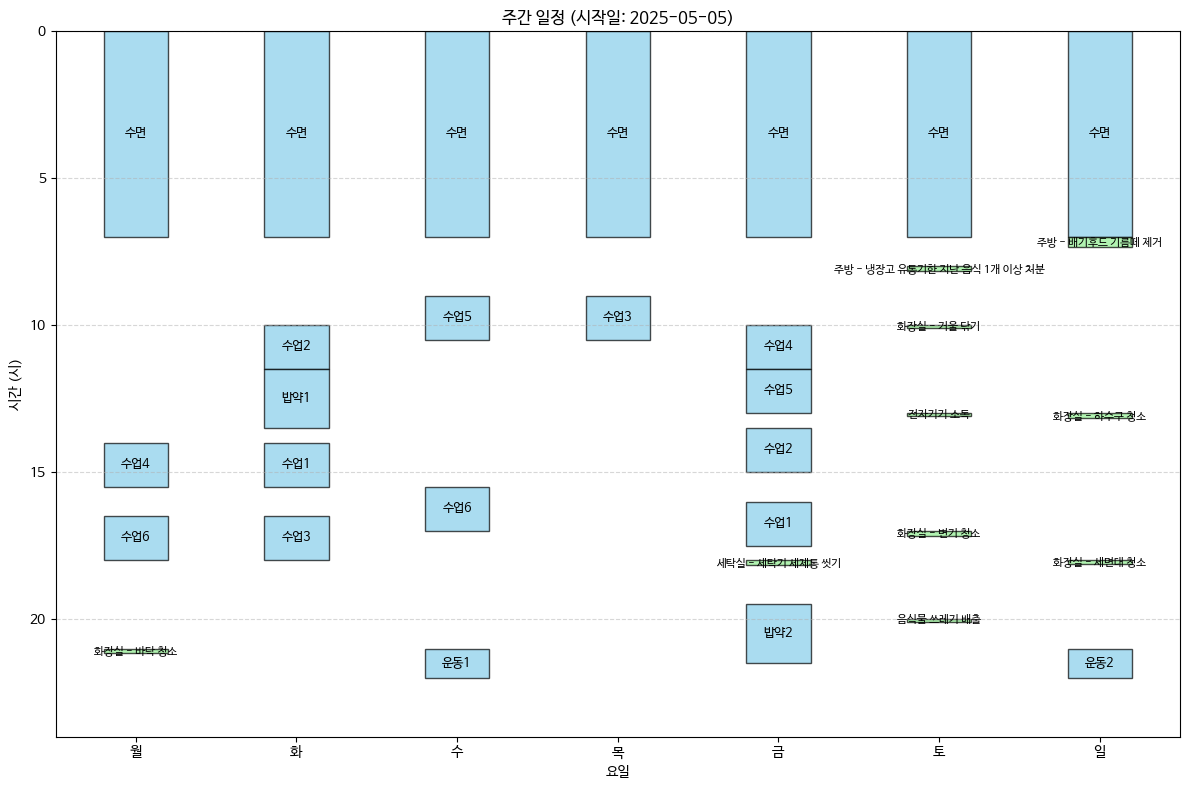

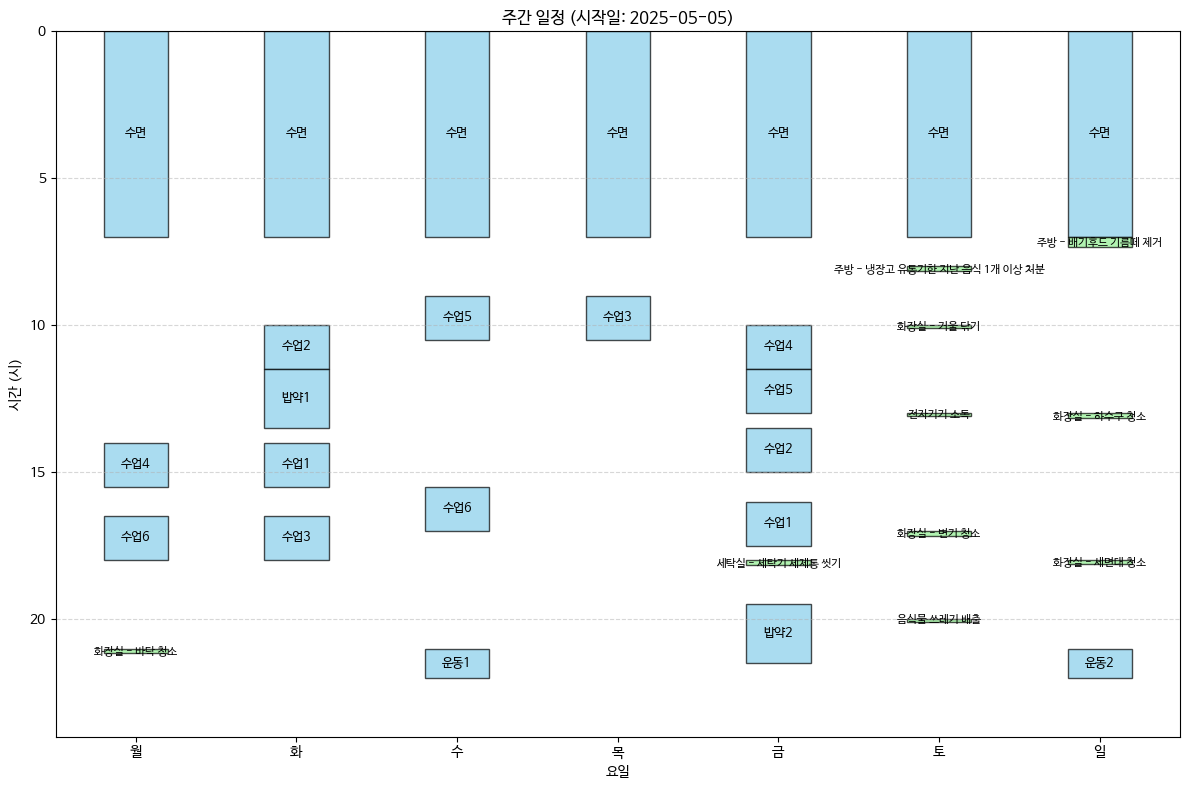

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- 2 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


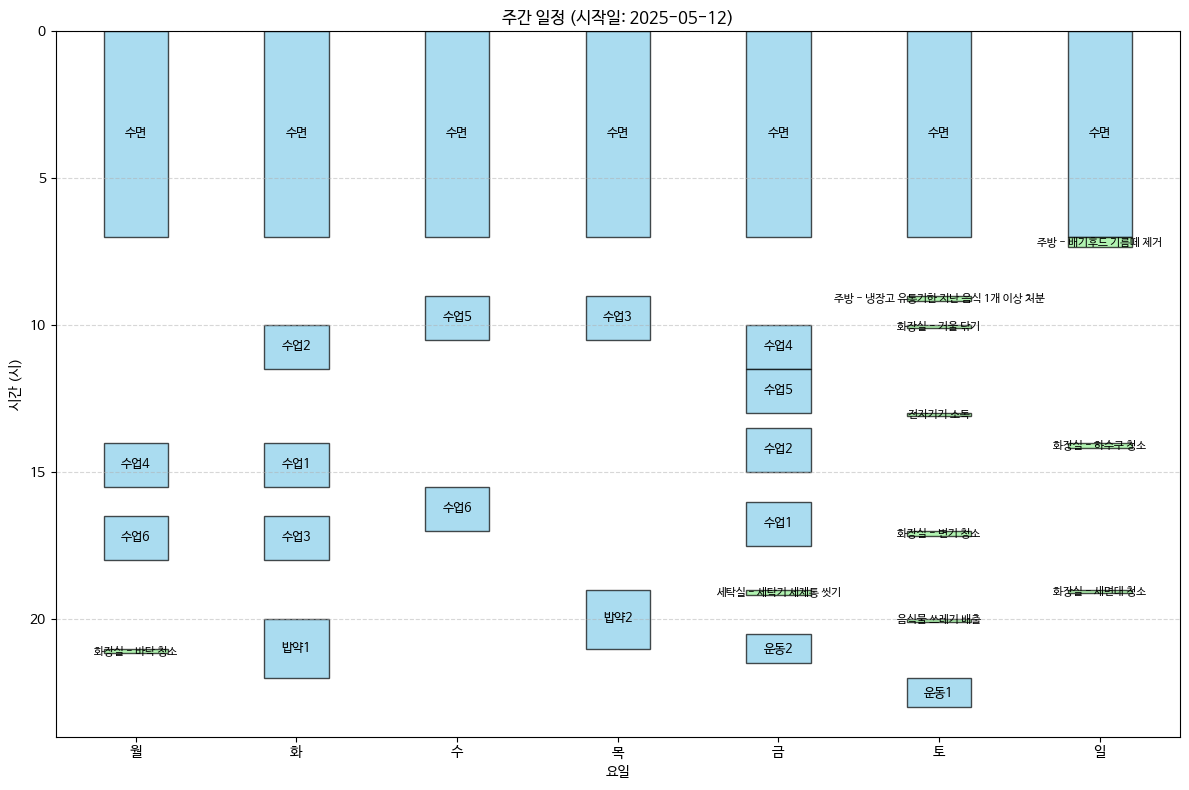

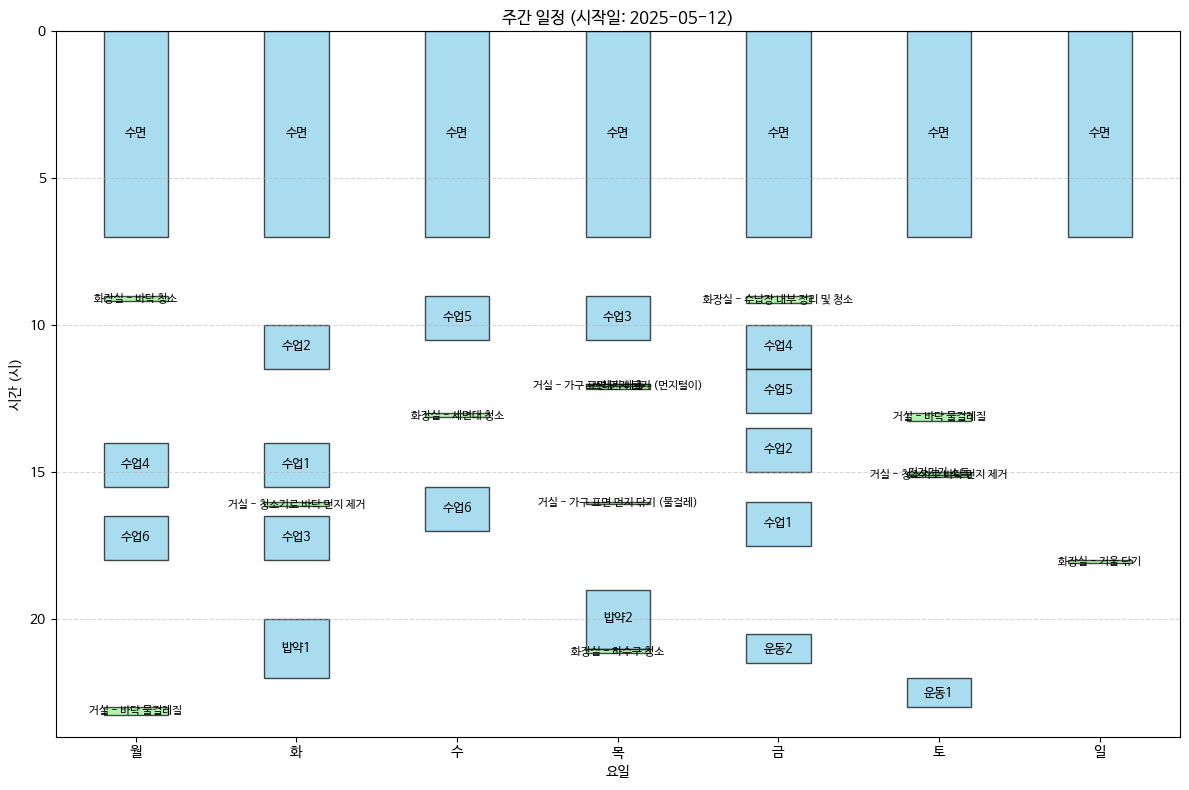

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- 3 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


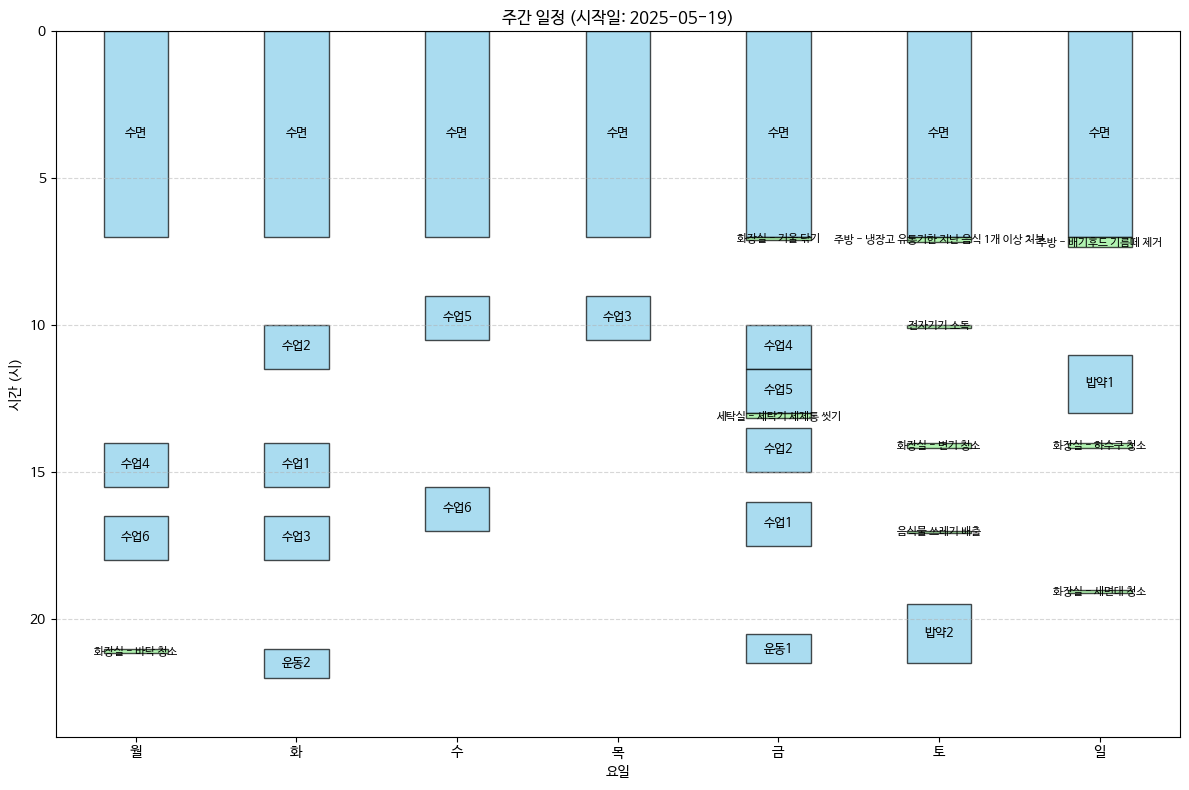

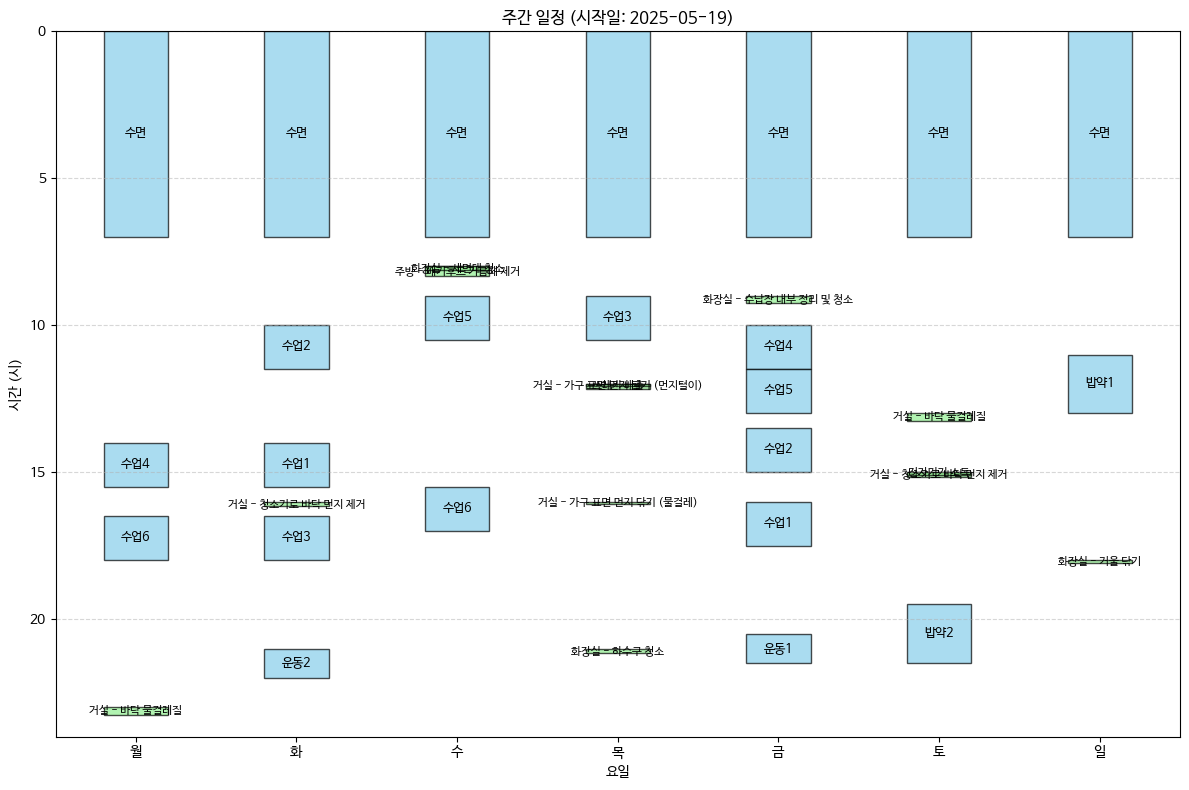

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- 4 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


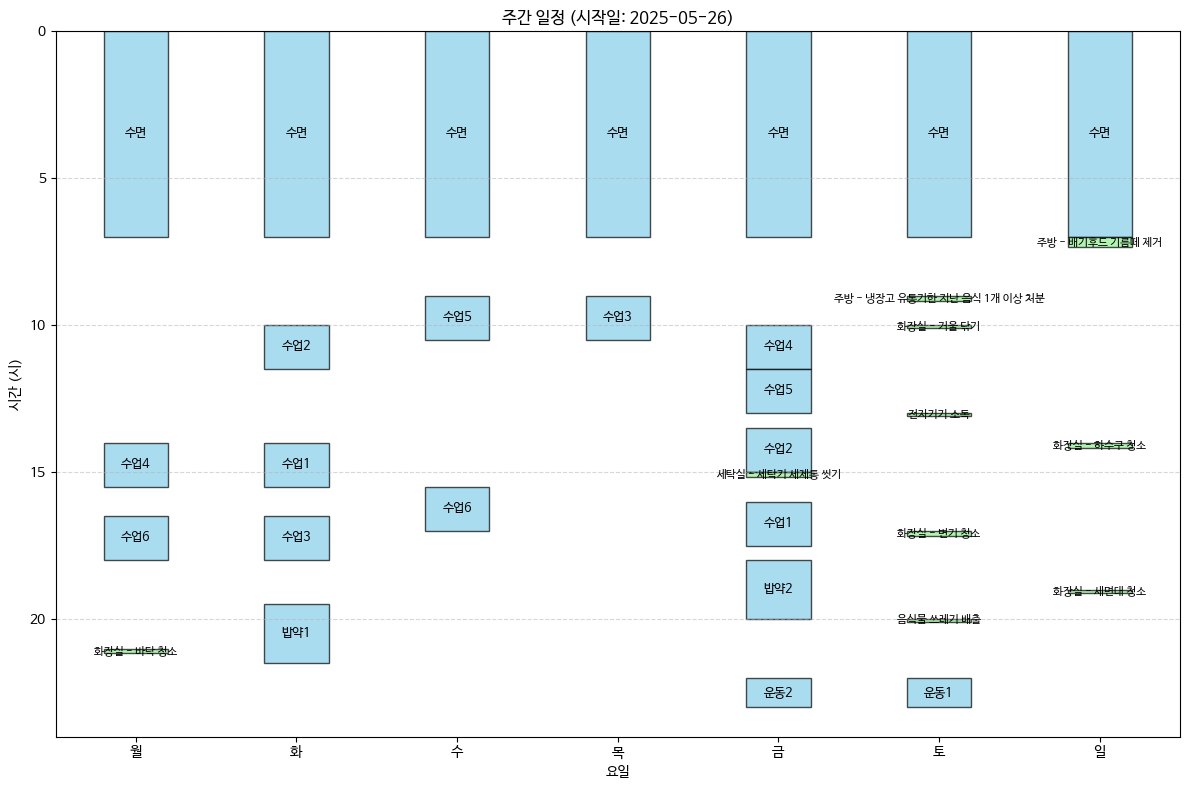

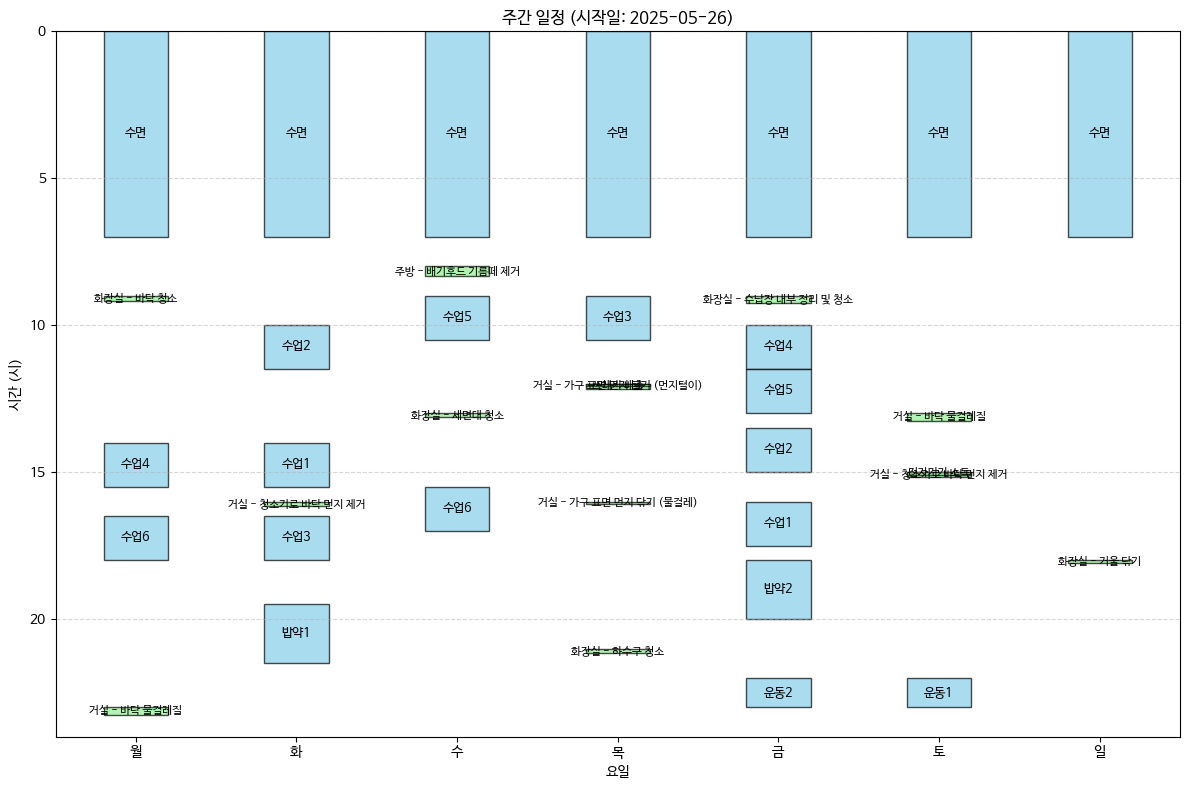

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- 5 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


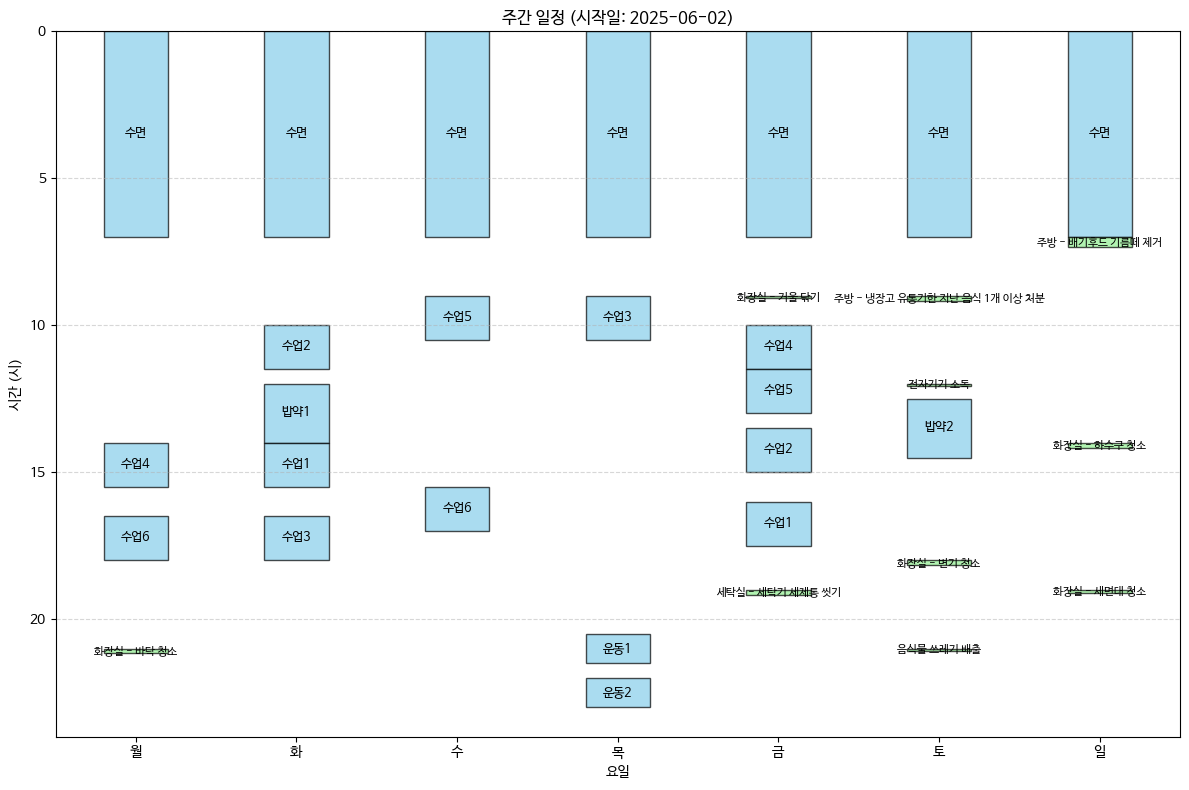

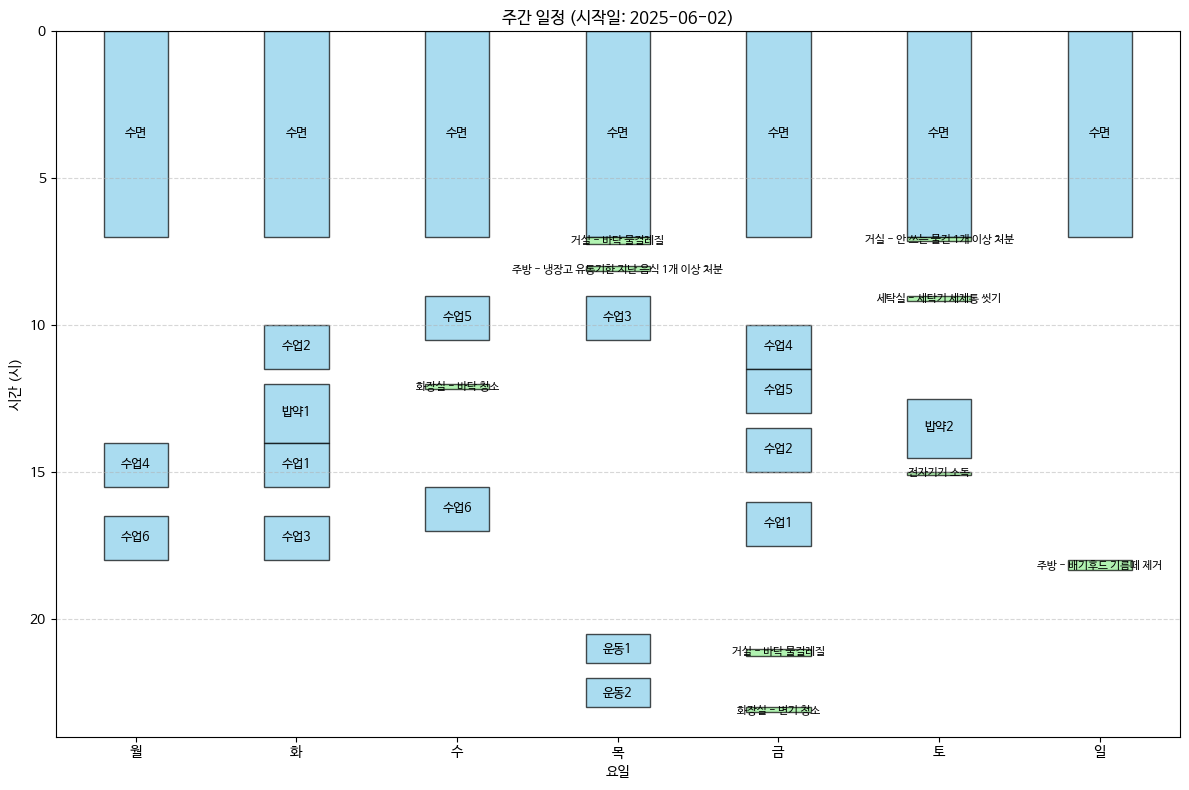

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- 6 ---


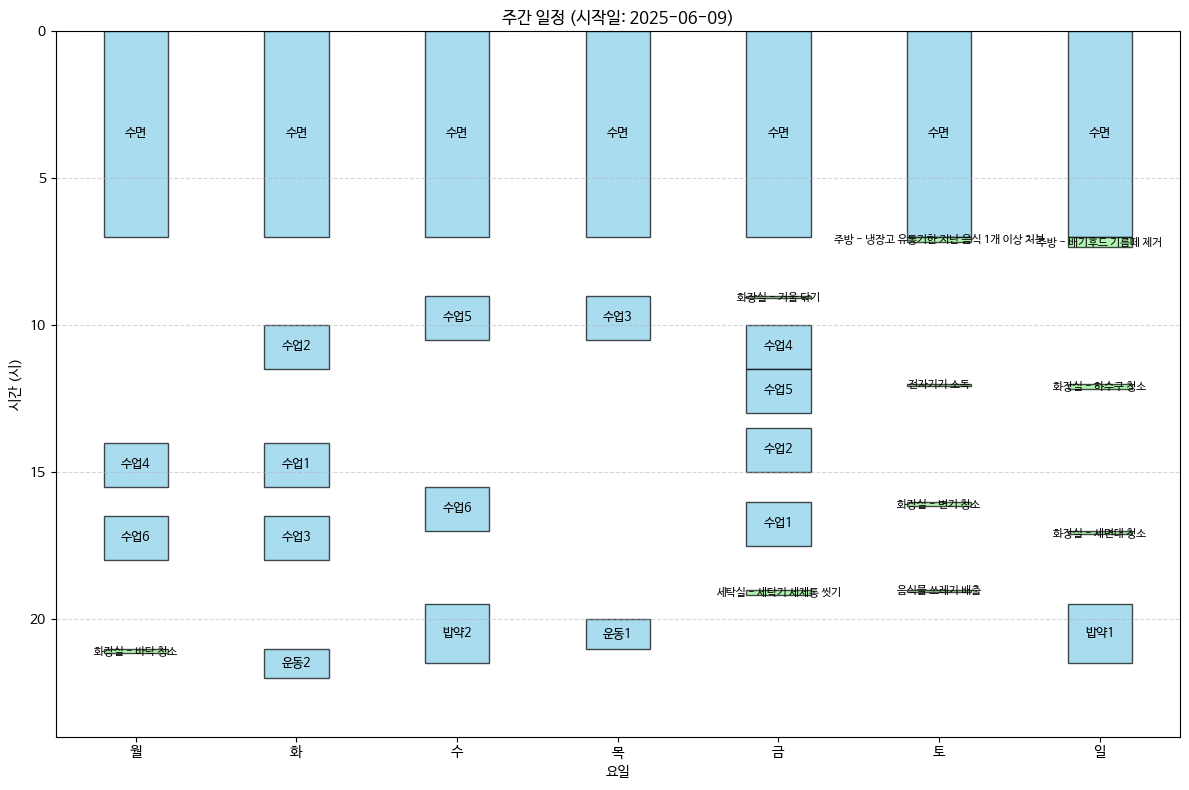

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


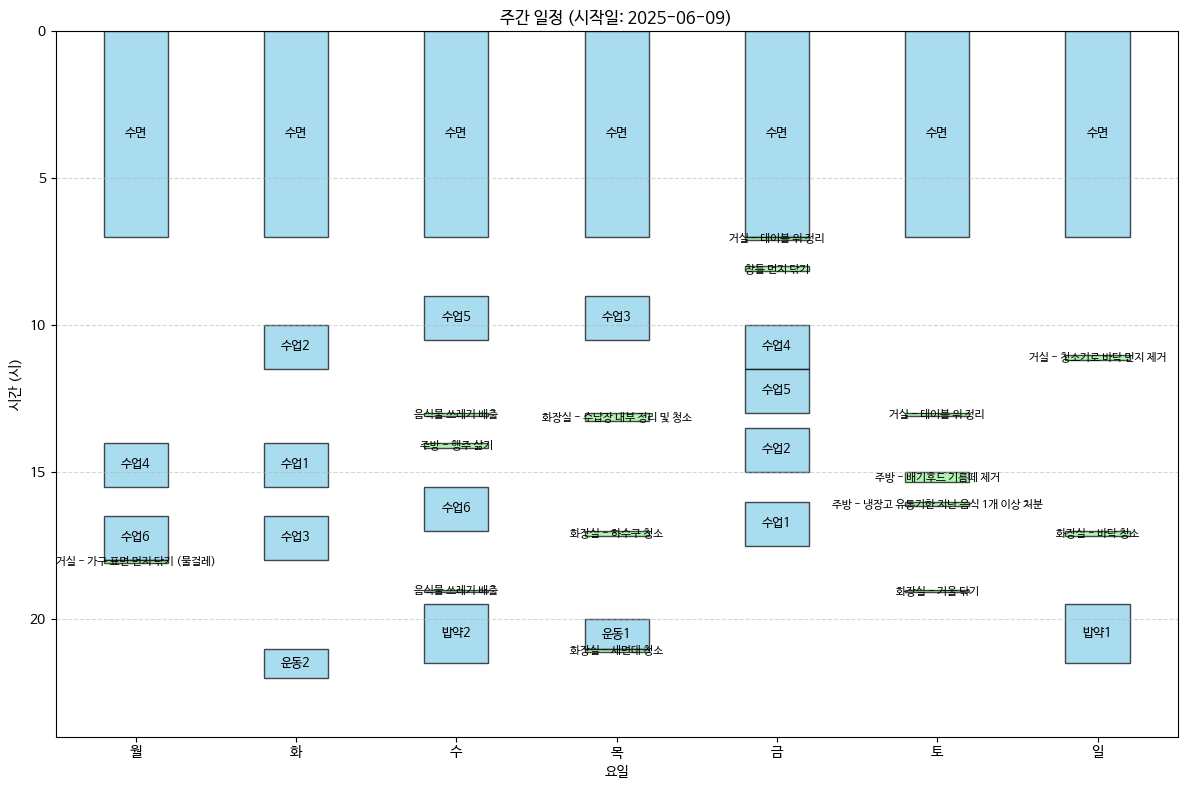

--- 7 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


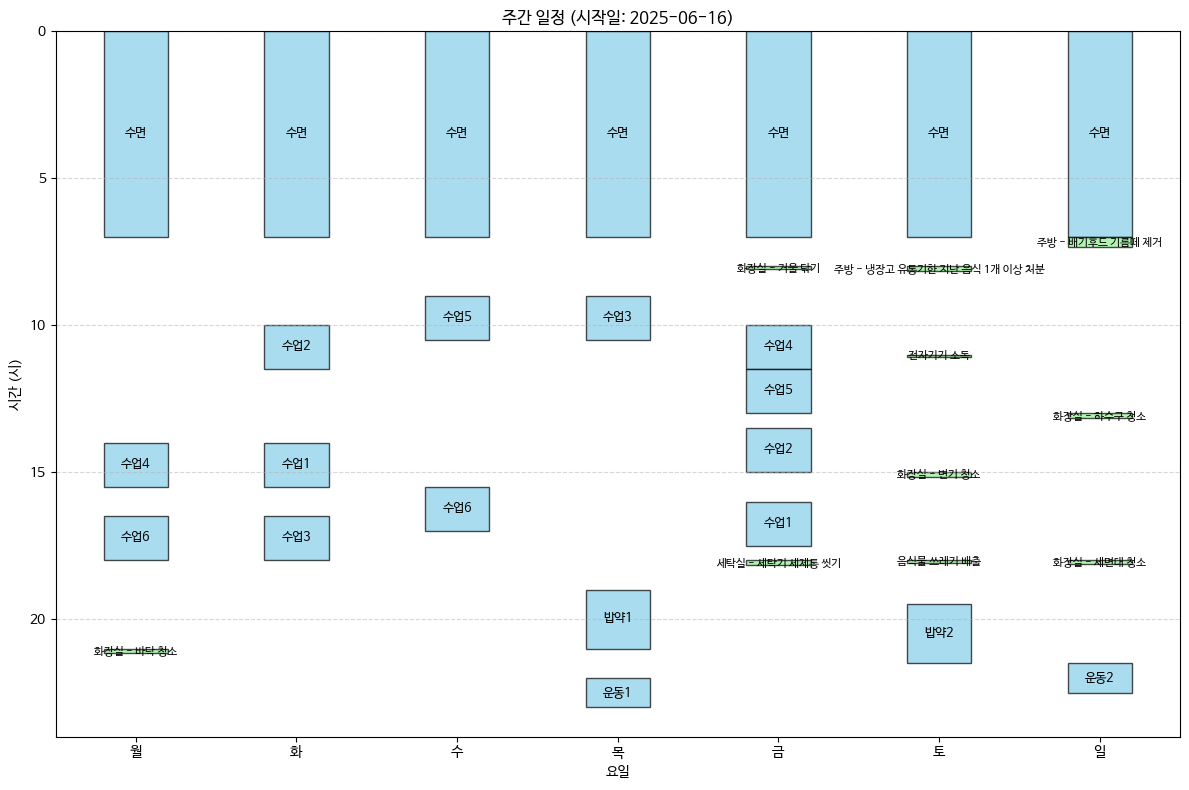

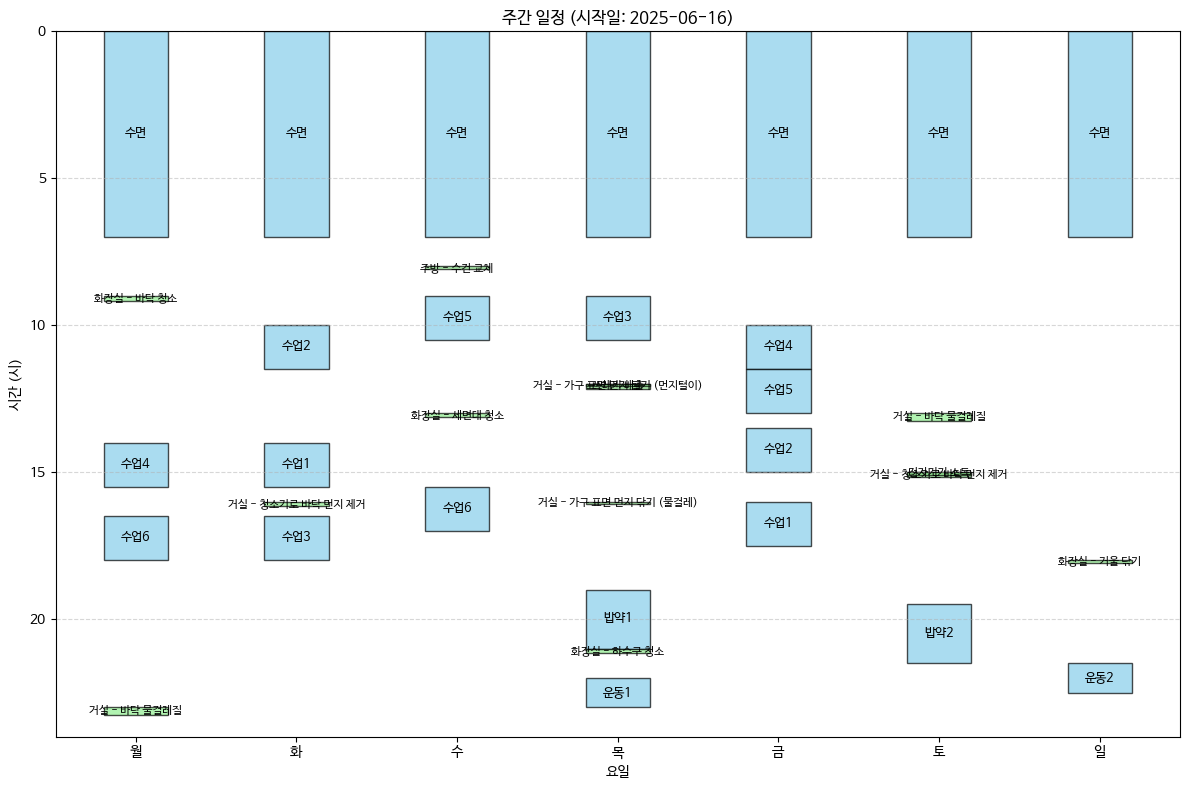

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- 8 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


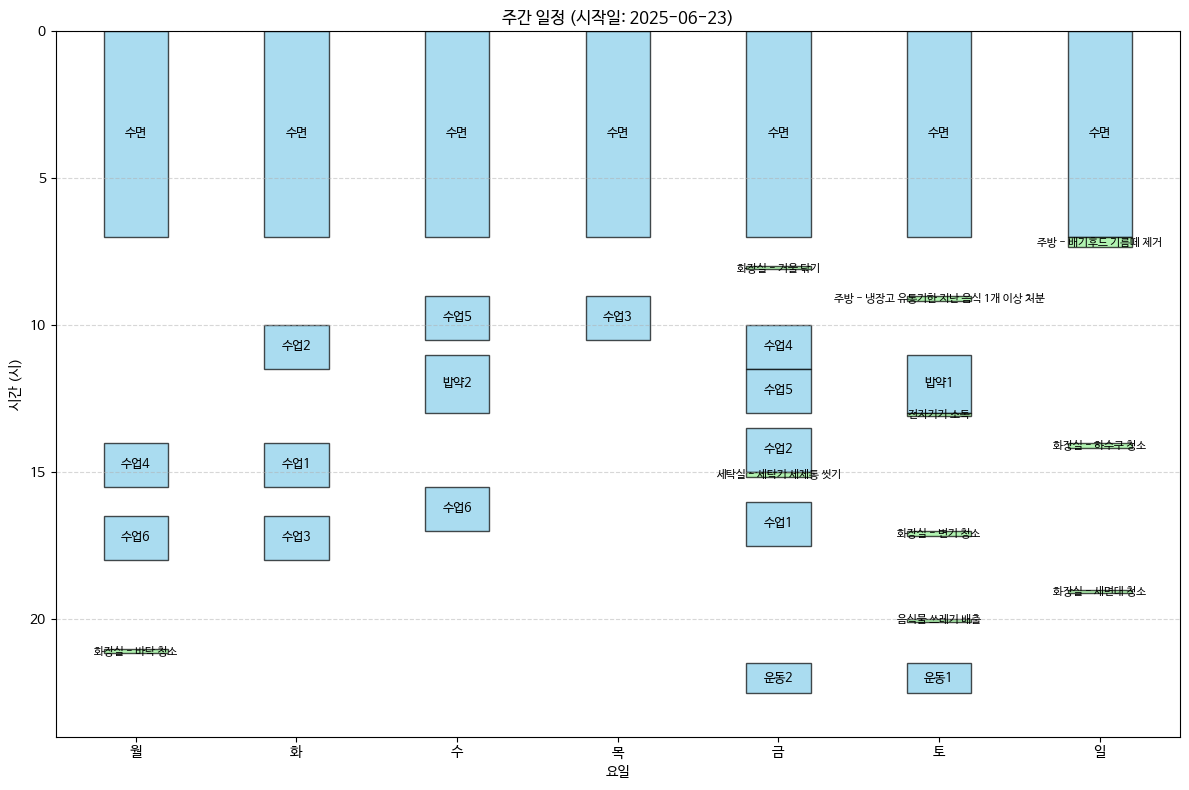

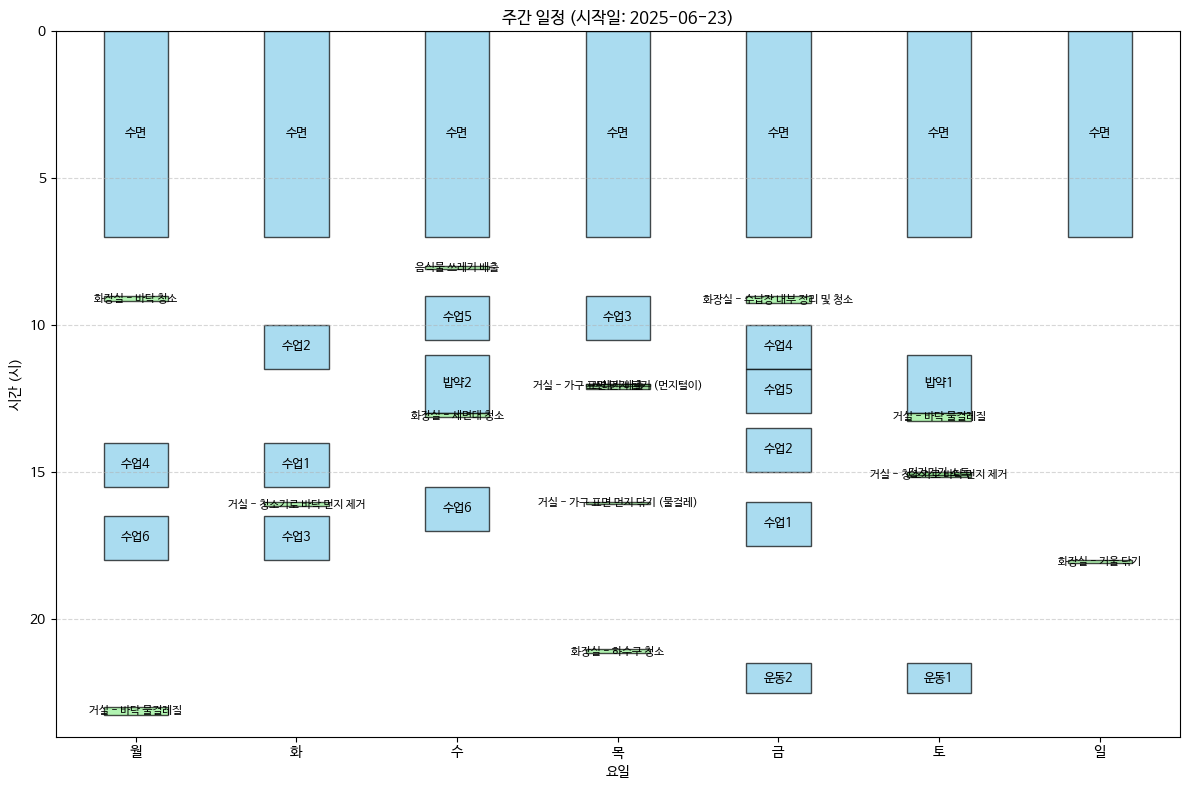

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- 9 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


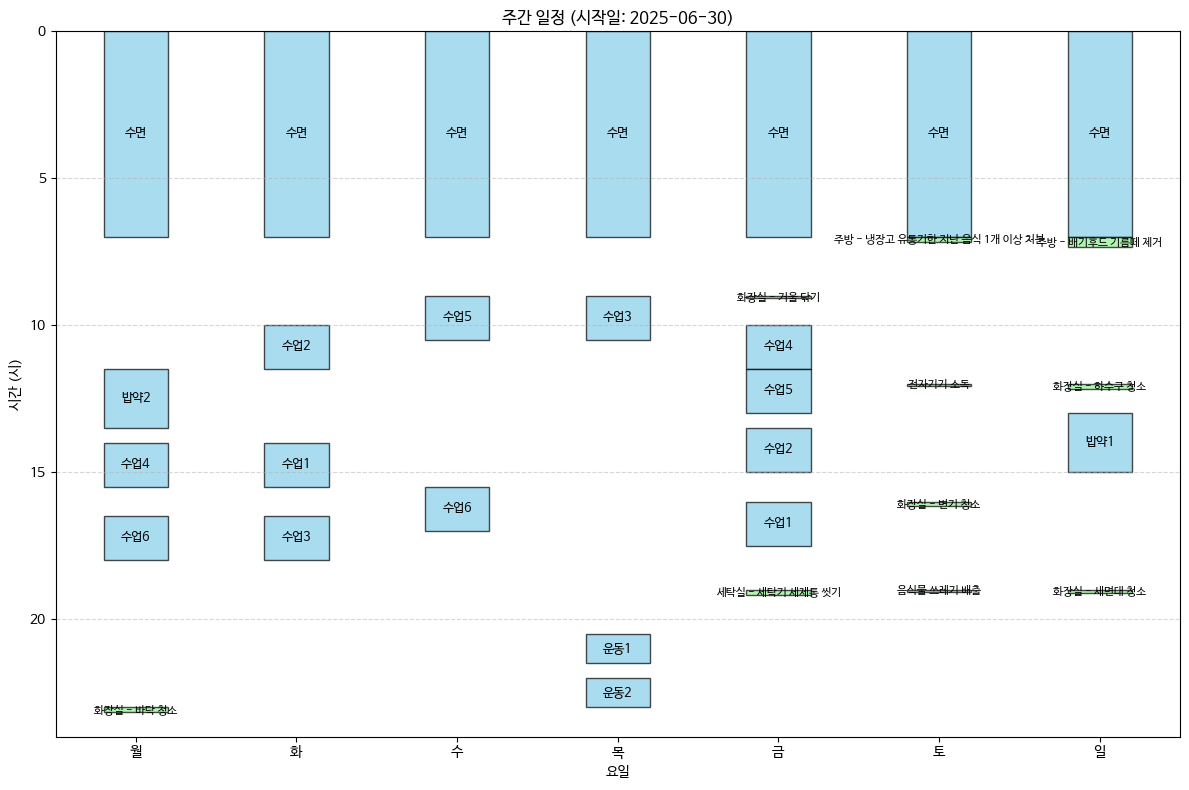

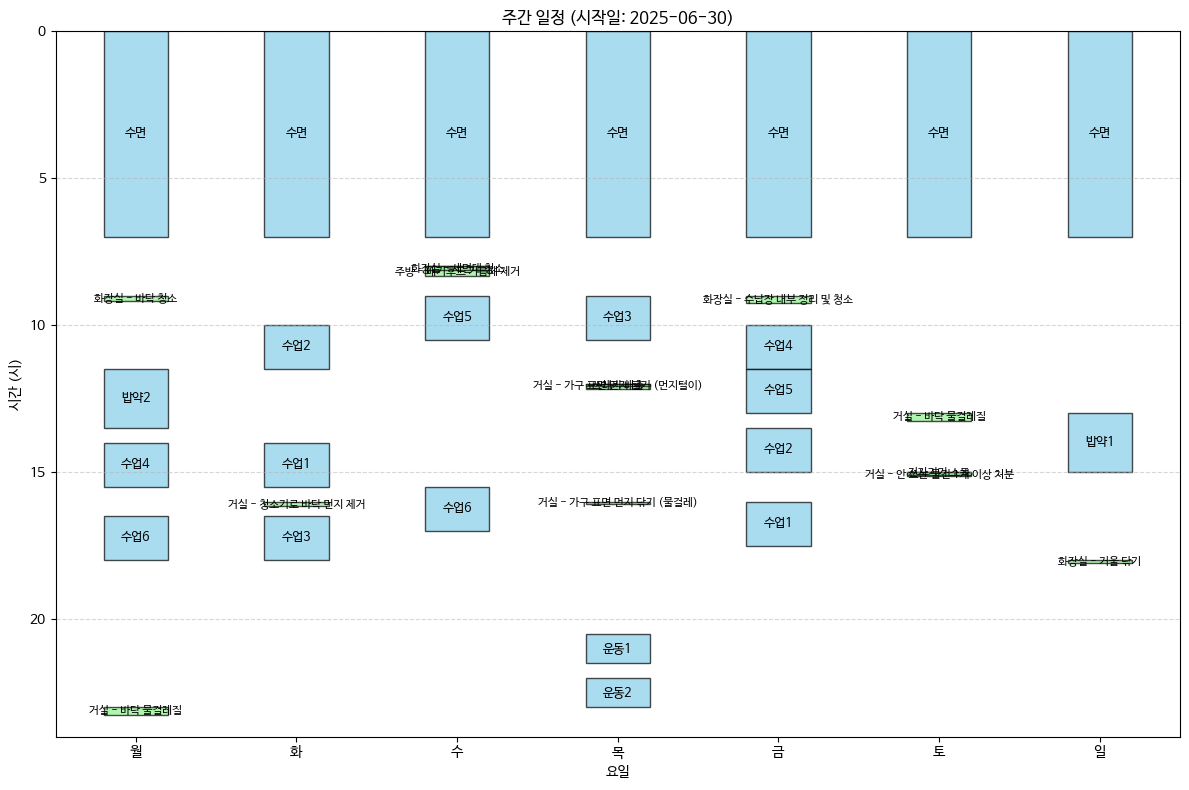

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- 10 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


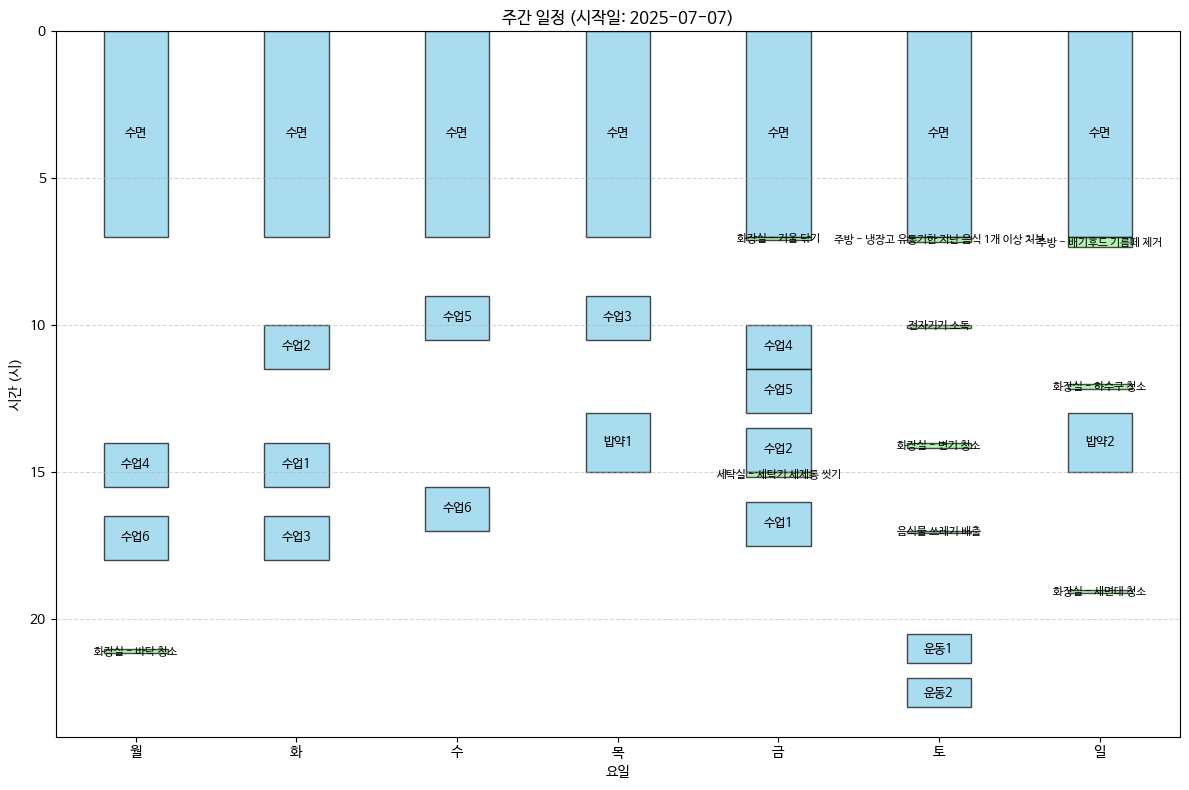

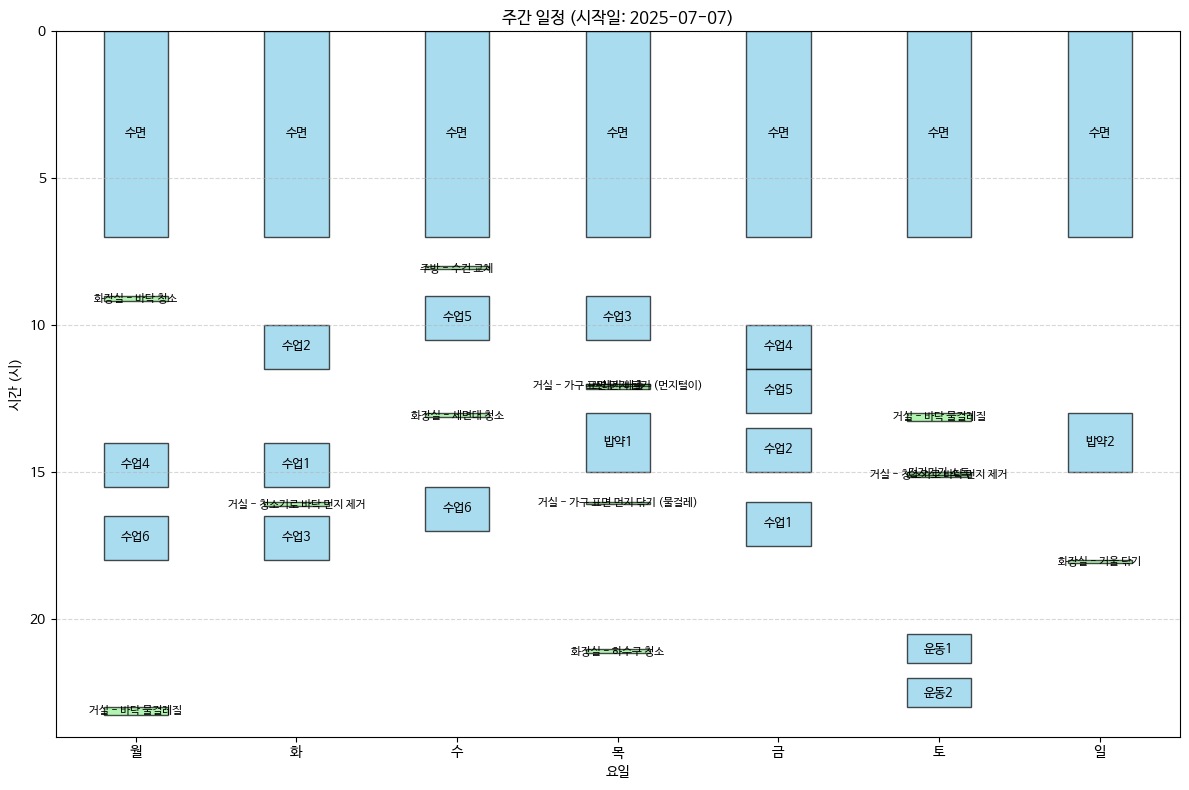

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
week_start = date(2025, 5, 5)

for i in range(WEEKS):
    print(f'--- {i + 1} ---')
    plot_weekly_schedule(fixed_schedules[i], initial_todos[i], week_start)
    plot_weekly_schedule(fixed_schedules[i], weekly_todos[i], week_start)
    week_start += timedelta(7)

## 내부 데이터 확인

In [ ]:
print('\n=== 마지막 수행일로부터 경과된 날짜 ===')
lst = [item for item in user_cleaning_status.items()]
print('\n'.join(map(str, lst)))


=== 마지막 수행일로부터 경과된 날짜 ===
('주방 - 수건 교체', {'last_done_days_ago': 19})
('주방 - 행주 삶기', {'last_done_days_ago': 26})
('주방 - 배기후드 기름떼 제거', {'last_done_days_ago': 5})
('주방 - 냉장고 유통기한 지난 음식 1개 이상 처분', {'last_done_days_ago': 23})
('세탁실 - 세탁기 세제통 씻기', {'last_done_days_ago': 30})
('화장실 - 바닥 청소', {'last_done_days_ago': 1})
('화장실 - 변기 청소', {'last_done_days_ago': 31})
('화장실 - 세면대 청소', {'last_done_days_ago': 4})
('화장실 - 하수구 청소', {'last_done_days_ago': 11})
('화장실 - 거울 닦기', {'last_done_days_ago': 1})
('화장실 - 수납장 내부 정리 및 청소', {'last_done_days_ago': 3})
('거실 - 가구 표면 먼지 닦기 (물걸레)', {'last_done_days_ago': 4})
('거실 - 가구 표면 먼지 털기 (먼지털이)', {'last_done_days_ago': 4})
('거실 - 바닥 물걸레질', {'last_done_days_ago': 2})
('거실 - 청소기로 바닥 먼지 제거', {'last_done_days_ago': 1})
('거실 - 테이블 위 정리', {'last_done_days_ago': 23})
('거실 - 안 쓰는 물건 1개 이상 처분', {'last_done_days_ago': 2})
('창틀 먼지 닦기', {'last_done_days_ago': 24})
('전자기기 소독', {'last_done_days_ago': 2})
('쓰레기 배출', {'last_done_days_ago': 4})
('음식물 쓰레기 배출', {'last_done_days_ago': 

In [ ]:
print('\n=== 청소 목록 ===')
print('\n'.join(map(str, cleaning_tasks)))


=== 청소 목록 ===
{'주방 - 수건 교체': {'duration': 0.08333333333333333, 'interval': 5, 'description': '깨끗한 수건으로 교체 후 사용한 수건은 세탁 바구니에 넣기'}}
{'주방 - 행주 삶기': {'duration': 0.16666666666666666, 'interval': 7, 'description': '행주를 삶거나 세탁기에 고온세탁하여 위생 관리'}}
{'주방 - 배기후드 기름떼 제거': {'duration': 0.3333333333333333, 'interval': 30, 'description': '기름 제거제를 뿌리고 문질러 닦은 후 물로 헹구기'}}
{'주방 - 냉장고 유통기한 지난 음식 1개 이상 처분': {'duration': 0.16666666666666666, 'interval': 7, 'description': '유통기한 지난 식품 확인 후 폐기'}}
{'세탁실 - 세탁기 세제통 씻기': {'duration': 0.16666666666666666, 'interval': 30, 'description': '세제 찌꺼기를 제거하고 물로 헹군 후 건조'}}
{'화장실 - 바닥 청소': {'duration': 0.16666666666666666, 'interval': 14, 'description': '바닥에 락스를 뿌리고 청소솔과 세제로 구석구석 닦기'}}
{'화장실 - 변기 청소': {'duration': 0.16666666666666666, 'interval': 7, 'description': '변기 전용 세제로 내부와 테두리 문지르기'}}
{'화장실 - 세면대 청소': {'duration': 0.11666666666666667, 'interval': 5, 'description': '물때와 치약 자국 등을 세정제로 제거'}}
{'화장실 - 하수구 청소': {'duration': 0.16666666666666666, 'interval': 7, 'description': '